In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pmdarima as pm


/Users/timhong/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
data = pd.read_excel("owid-covid-data.xlsx")
data.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,population,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,AFG,Asia,Afghanistan,2020-01-03,NaN,0.0,NaN,NaN,0.0,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772,NaN,NaN,NaN,NaN
1,AFG,Asia,Afghanistan,2020-01-04,NaN,0.0,NaN,NaN,0.0,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772,NaN,NaN,NaN,NaN
2,AFG,Asia,Afghanistan,2020-01-05,NaN,0.0,NaN,NaN,0.0,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772,NaN,NaN,NaN,NaN
3,AFG,Asia,Afghanistan,2020-01-06,NaN,0.0,NaN,NaN,0.0,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772,NaN,NaN,NaN,NaN
4,AFG,Asia,Afghanistan,2020-01-07,NaN,0.0,NaN,NaN,0.0,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772,NaN,NaN,NaN,NaN


In [3]:
country_list = [
    'Spain', 'France', 'Germany', 'Ireland', 'United Kingdom',
    'Italy', 'Belgium', 'Netherlands', 'Switzerland', 'Luxembourg'
]

selected_data = data[data['location'].isin(country_list)]
selected_data.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,population,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
28497,BEL,Europe,Belgium,2020-01-03,NaN,0.0,NaN,NaN,0.0,NaN,...,31.4,NaN,5.64,81.63,0.931,11655923,NaN,NaN,NaN,NaN
28498,BEL,Europe,Belgium,2020-01-04,NaN,0.0,NaN,NaN,0.0,NaN,...,31.4,NaN,5.64,81.63,0.931,11655923,NaN,NaN,NaN,NaN
28499,BEL,Europe,Belgium,2020-01-05,NaN,0.0,NaN,NaN,0.0,NaN,...,31.4,NaN,5.64,81.63,0.931,11655923,-151.3,-6.34,-6.34,-13.086293
28500,BEL,Europe,Belgium,2020-01-06,NaN,0.0,NaN,NaN,0.0,NaN,...,31.4,NaN,5.64,81.63,0.931,11655923,NaN,NaN,NaN,NaN
28501,BEL,Europe,Belgium,2020-01-07,NaN,0.0,NaN,NaN,0.0,NaN,...,31.4,NaN,5.64,81.63,0.931,11655923,NaN,NaN,NaN,NaN


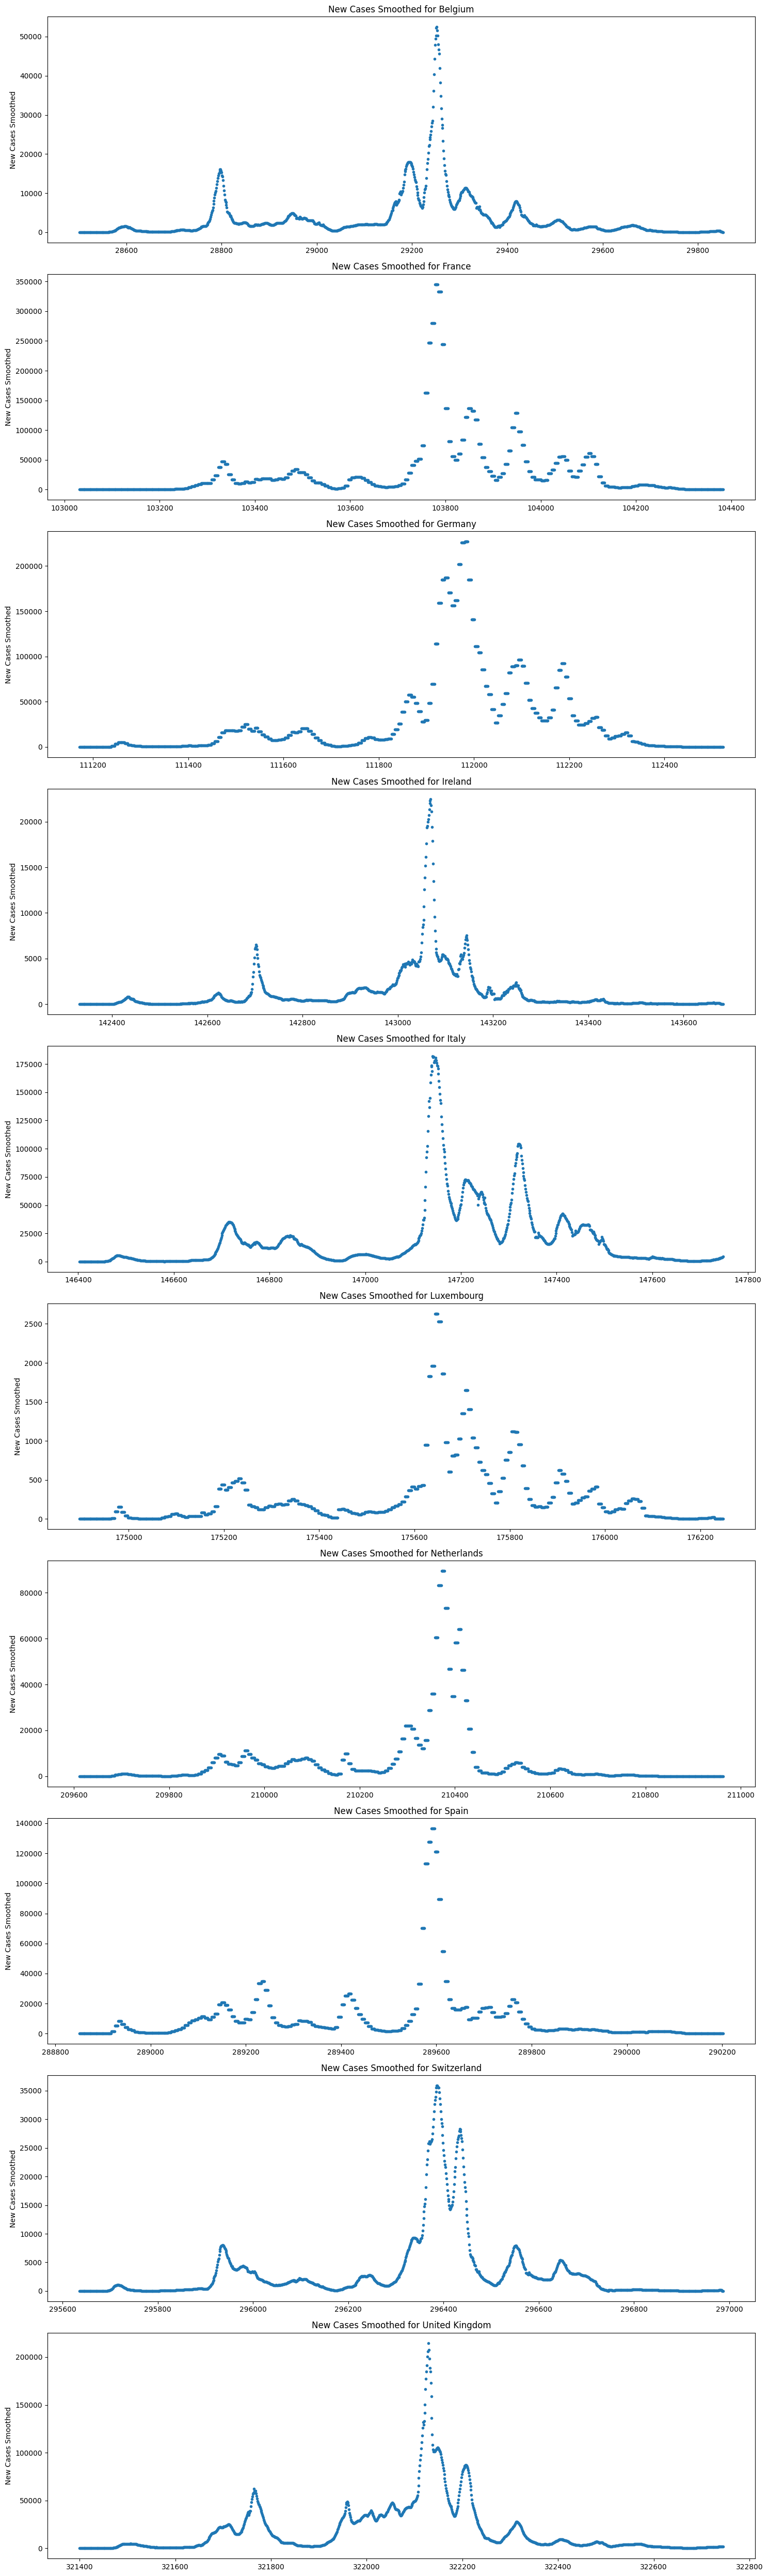

In [4]:
locations = selected_data['location'].unique()
plt.figure(figsize=(15, 5 * len(locations)))

for i, location in enumerate(locations, 1):
    plt.subplot(len(locations), 1, i)
    selected_data[selected_data['location'] == location]['new_cases_smoothed'].plot(style='.', title=f'New Cases Smoothed for {location}')
    plt.ylabel('New Cases Smoothed')

plt.tight_layout()
plt.show()

Seems like we should isolate the parts of the data that matter - beginning and end dates contain a bunch of 0s.

## Data Cleaning

### Removing irrelevant variables

In [5]:
data_clean = selected_data[["location", "date", "new_cases_smoothed"]]
data_clean.head()

,location,date,new_cases_smoothed
28497,Belgium,2020-01-03,NaN
28498,Belgium,2020-01-04,NaN
28499,Belgium,2020-01-05,NaN
28500,Belgium,2020-01-06,NaN
28501,Belgium,2020-01-07,NaN


### Removing irrelevant dates


In [6]:
### Find first month where majority of new_cases_smoothed isn't NaN/0 
# Convert 'ds' to datetime if it's not already
data_clean['date'] = pd.to_datetime(data_clean['date'])

# 2020 - first month
df_2020 = data_clean[data_clean['date'].dt.year == 2020]

# Count the number of days with new_cases not 0 or NA for each month
monthly_counts_2020 = df_2020[(df_2020['new_cases_smoothed'] != 0) | 
                              df_2020['new_cases_smoothed'].isna()].groupby(df_2020['date'].dt.to_period('M')).size()



# 2023 - last month
df_2023 = data_clean[data_clean['date'].dt.year == 2023]

# Count the number of days with new_cases not 0 or NA for each month
monthly_counts_2023 = df_2023[(df_2023['new_cases_smoothed'] != 0) | 
                              df_2023['new_cases_smoothed'].isna()].groupby(df_2023['date'].dt.to_period('M')).size()


/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/ipykernel_69675/1875676307.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_clean['date'] = pd.to_datetime(data_clean['date'])


In [7]:
monthly_counts_2020

date
2020-01     79
2020-02    135
2020-03    276
2020-04    270
2020-05    294
2020-06    300
2020-07    310
2020-08    310
2020-09    300
2020-10    310
2020-11    300
2020-12    310
Freq: M, dtype: int64

In [8]:
monthly_counts_2023

date
2023-01    310
2023-02    280
2023-03    310
2023-04    300
2023-05    310
2023-06    300
2023-07    234
2023-08    217
2023-09     99
Freq: M, dtype: int64

Our selected_data tracks 10 countries, so there should be ~10 observations a day for the ~30 a month totalling to 300-310 observations that should be tracked per month. 

Looking at 2020, 2020-03 is the first month where there are over 90% non-zero, non-missing observations.
Looking at 2023, 2023-06 is the last month where there are over 90% non-zero, non-missing observations. 

Thus, I'm first going to subset my data to go from 2020-03-01 to 2023-08-01.

In [9]:
# Subset the dataset
data_clean_subset = data_clean[(data_clean['date'] >= '2020-03-01') & (data_clean['date'] <= '2023-06-30')]

In [10]:
# check missingness
missing_values_count = data_clean_subset['new_cases_smoothed'].isnull().sum()
print(missing_values_count)

0


No NA values - good


### Removing Outliers


/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/ipykernel_69675/3317855334.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  outliers_df = pd.concat([outliers_df, outliers_location])


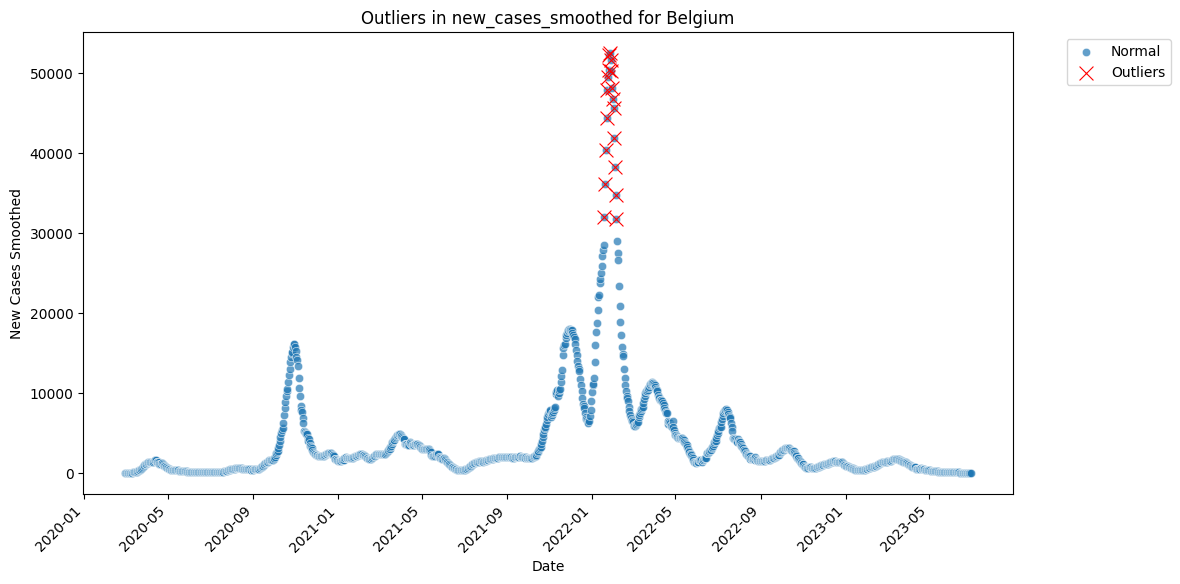

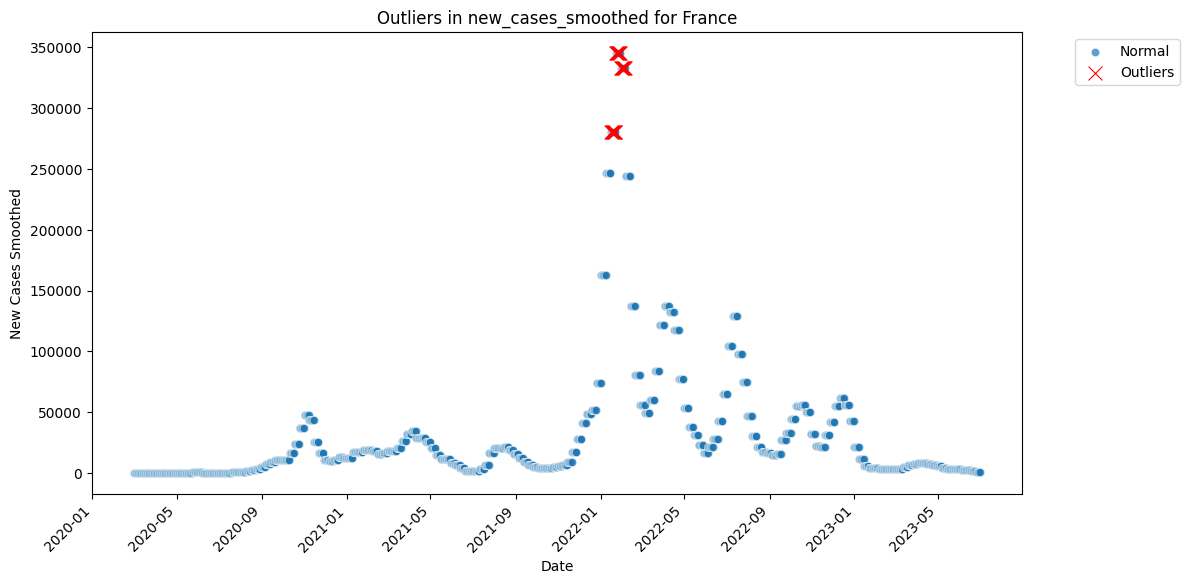

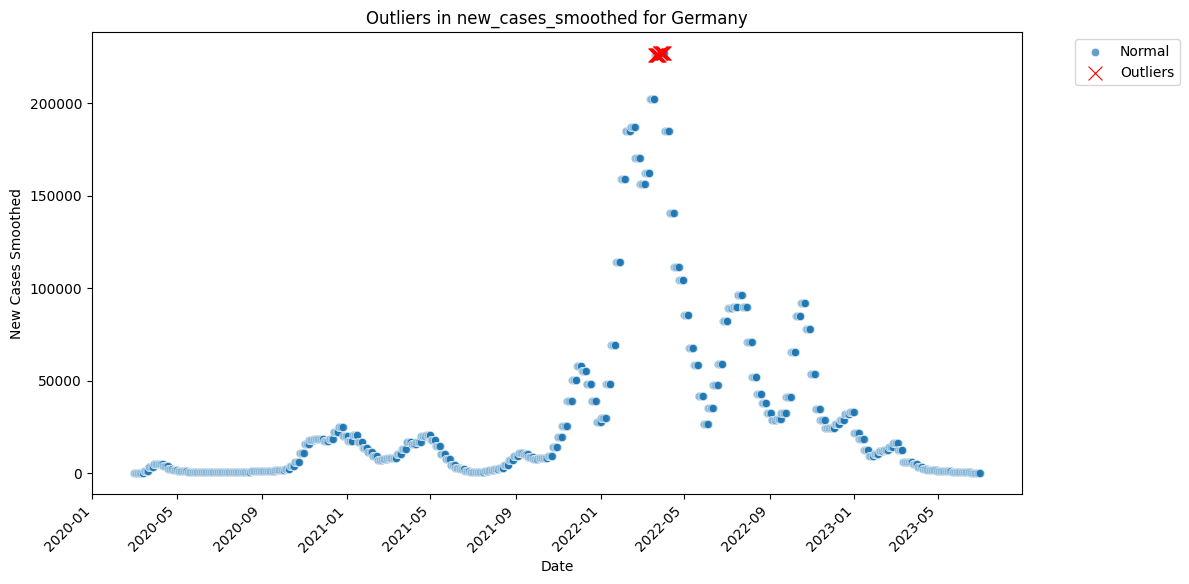

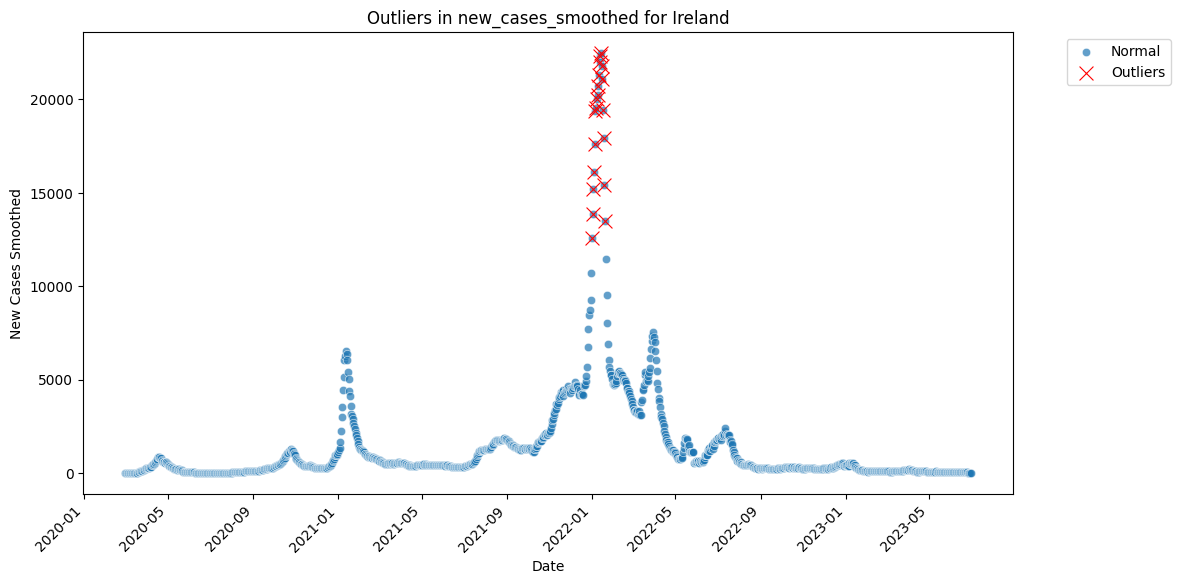

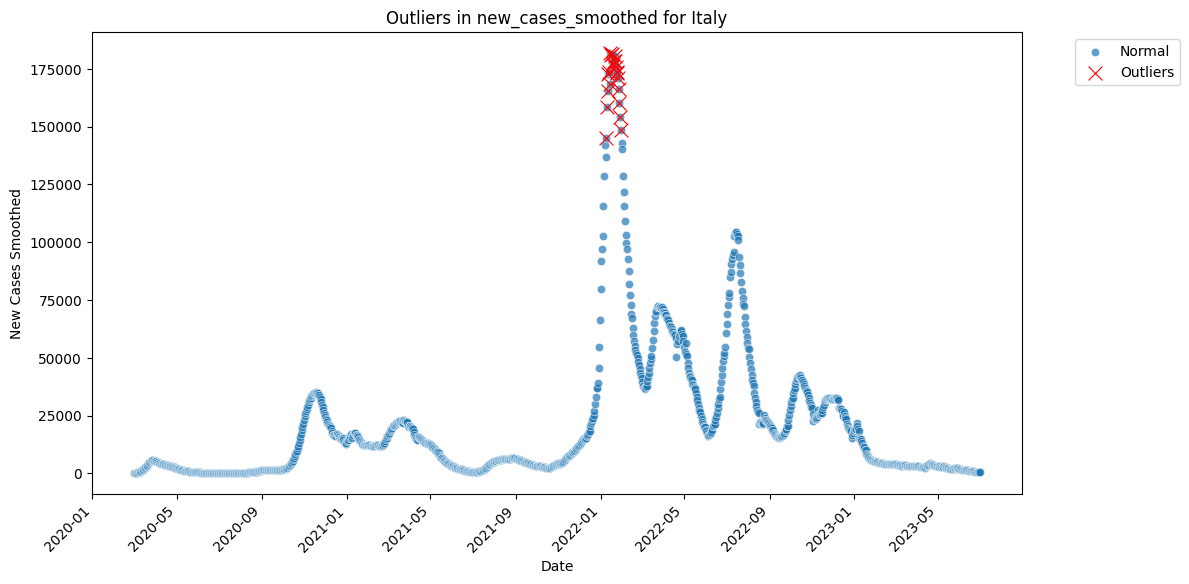

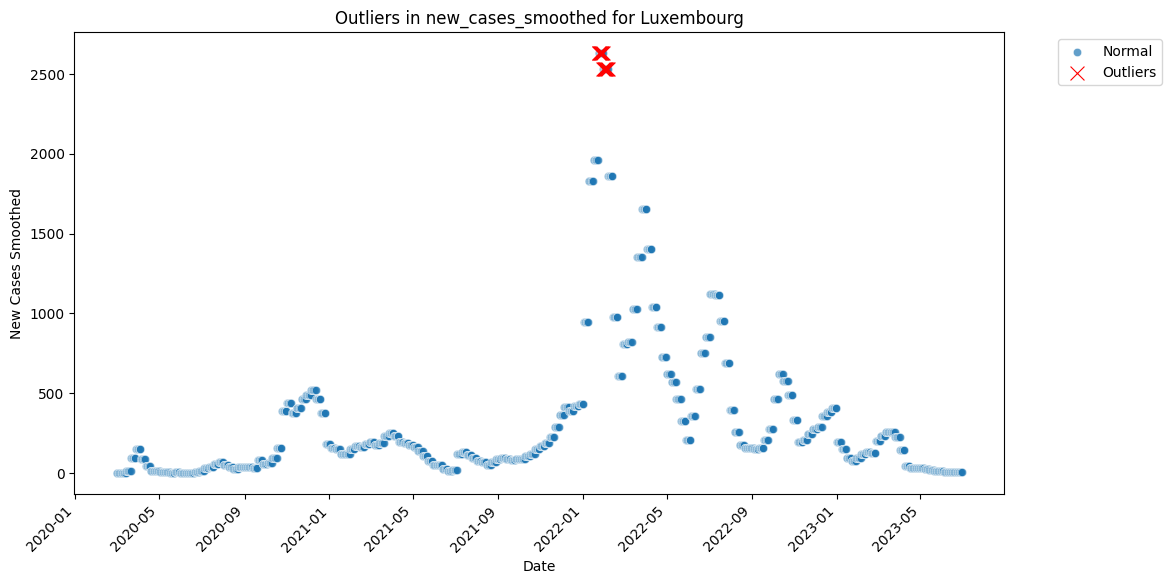

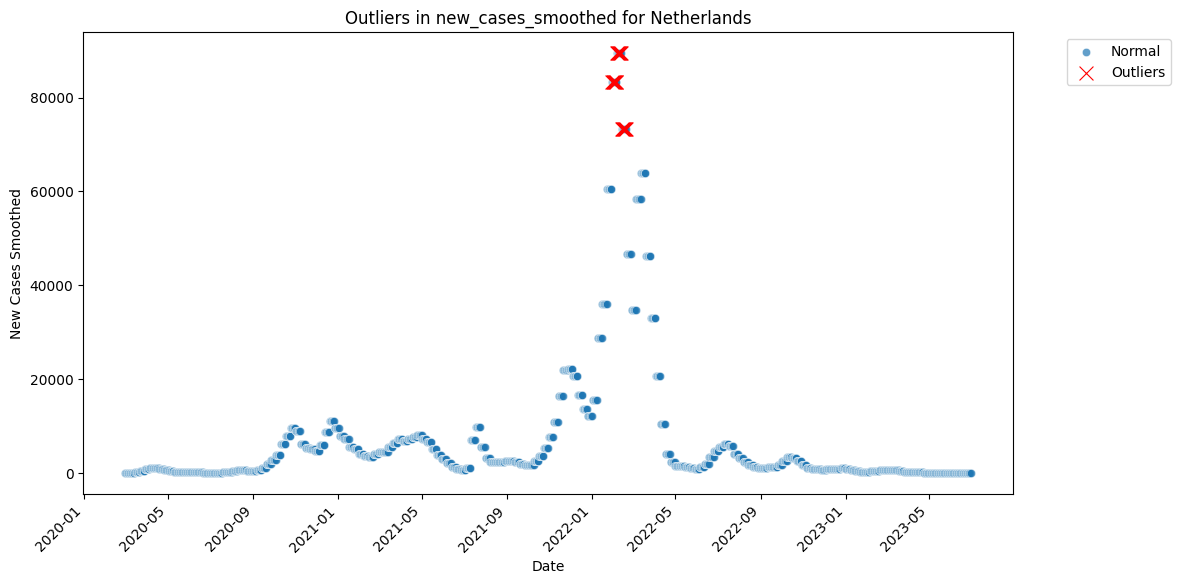

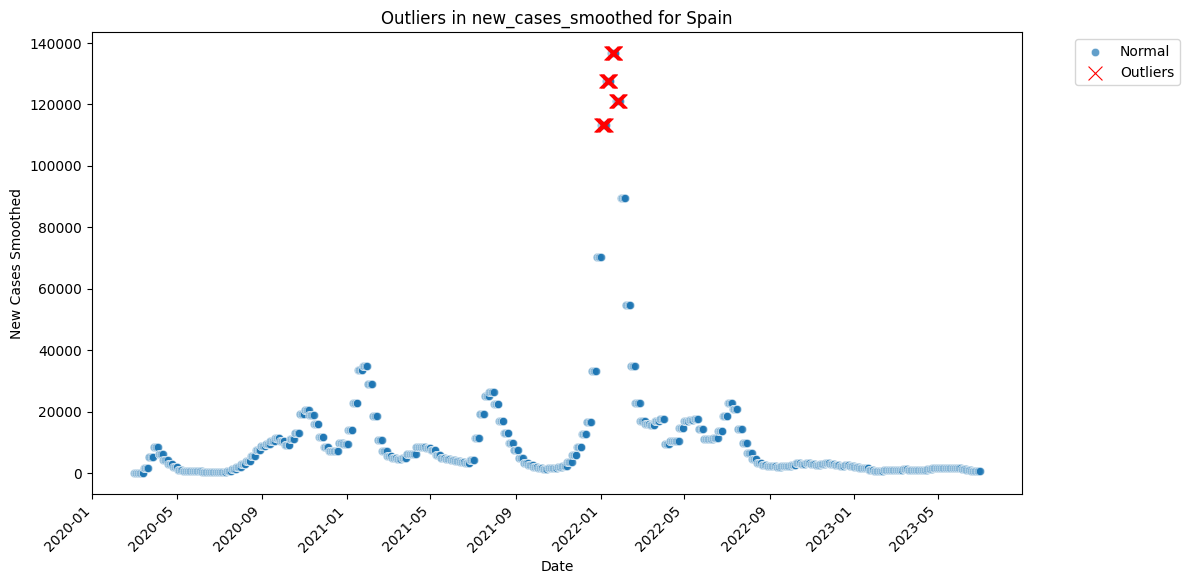

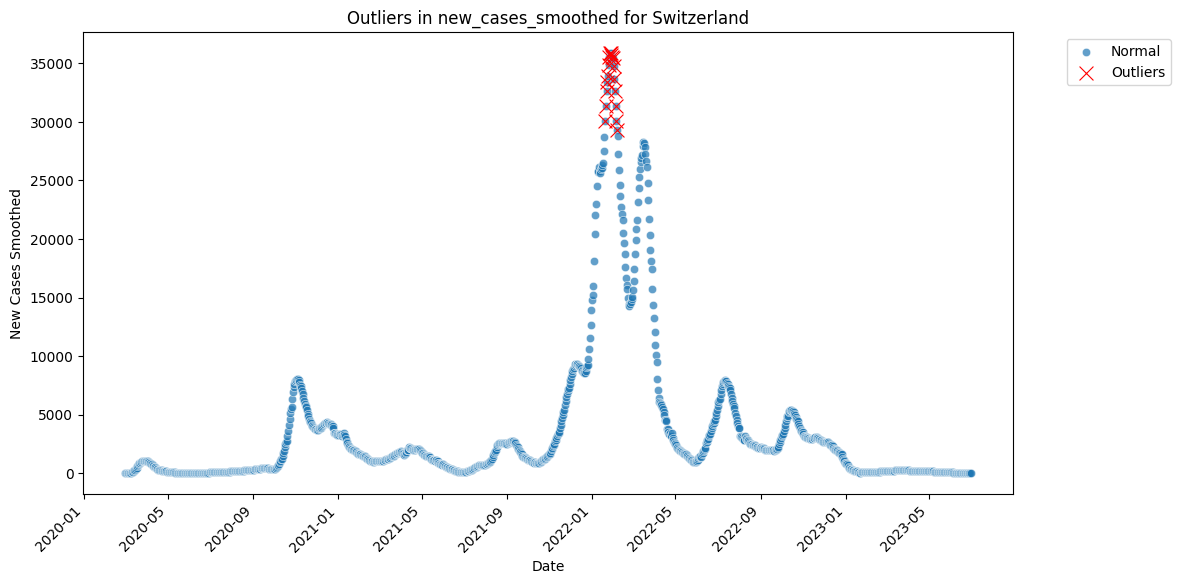

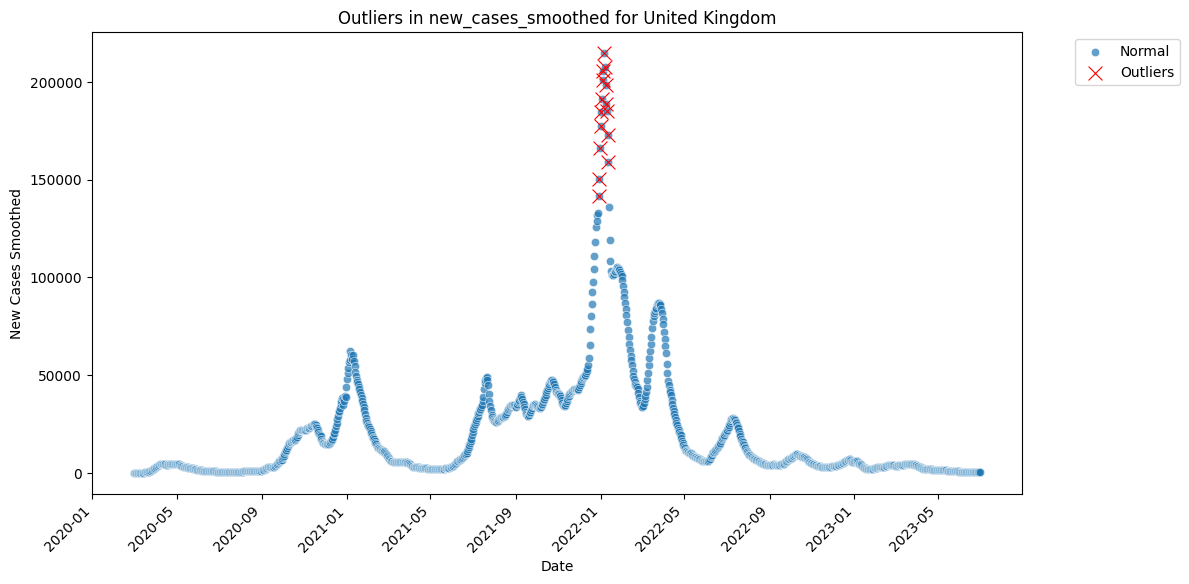

In [11]:
from scipy import stats

# Function to identify outliers using z-score
def detect_outliers_zscore(data):
    z_scores = stats.zscore(data)
    return (abs(z_scores) > 4)

# Identify outliers for each location
outliers_df = pd.DataFrame(columns=data_clean_subset.columns)
for location, group in data_clean_subset.groupby('location'):
    outliers_location = group[detect_outliers_zscore(group['new_cases_smoothed'])]
    outliers_df = pd.concat([outliers_df, outliers_location])

# Plot each location's points with outliers highlighted in separate plots
for location, group in data_clean_subset.groupby('location'):
    outliers_location = group[detect_outliers_zscore(group['new_cases_smoothed'])]

    plt.figure(figsize=(12, 6))
    sns.scatterplot(x='date', y='new_cases_smoothed', data=group, alpha=0.7, label='Normal')
    sns.scatterplot(x='date', y='new_cases_smoothed', data=outliers_location, marker='x', s=100, color='red', label='Outliers')
    plt.title(f'Outliers in new_cases_smoothed for {location}')
    plt.xlabel('Date')
    plt.ylabel('New Cases Smoothed')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xticks(rotation=45, ha='right')
    plt.show()

In [12]:
# Function to remove outliers using z-score
def remove_outliers_zscore(data):
    z_scores = stats.zscore(data['new_cases_smoothed'])
    return data[(abs(z_scores) <= 4)]

# Remove outliers for each location
cleaned_df = pd.DataFrame(columns=data_clean_subset.columns)
for _, group in data_clean_subset.groupby('location'):
    cleaned_location = remove_outliers_zscore(group)
    cleaned_df = pd.concat([cleaned_df, cleaned_location])

# Display the cleaned DataFrame without outliers
print(cleaned_df)

              location       date  new_cases_smoothed
28555          Belgium 2020-03-01               0.000
28556          Belgium 2020-03-02               0.000
28557          Belgium 2020-03-03               2.571
28558          Belgium 2020-03-04               5.286
28559          Belgium 2020-03-05              10.143
...                ...        ...                 ...
322665  United Kingdom 2023-06-26             386.857
322666  United Kingdom 2023-06-27             379.143
322667  United Kingdom 2023-06-28             362.000
322668  United Kingdom 2023-06-29             346.857
322669  United Kingdom 2023-06-30             336.857

[11979 rows x 3 columns]


/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/ipykernel_69675/3310638494.py:10: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  cleaned_df = pd.concat([cleaned_df, cleaned_location])


## Time Series Decomposition

<Figure size 1000x600 with 0 Axes>

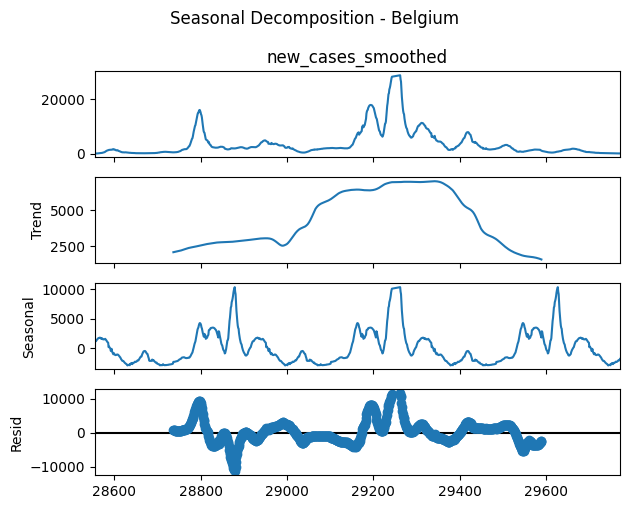

<Figure size 1000x600 with 0 Axes>

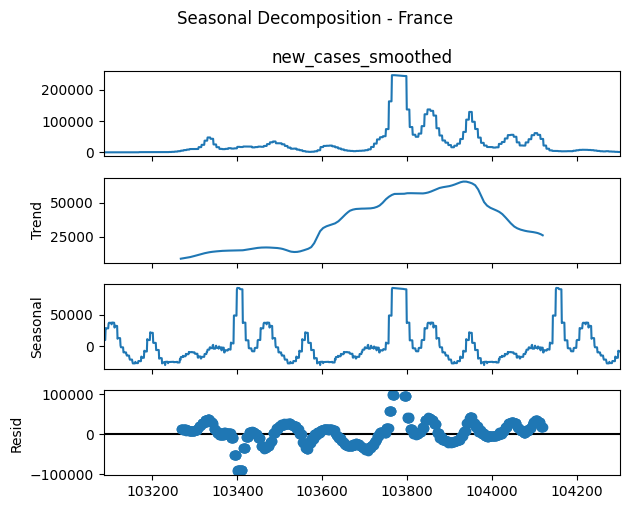

<Figure size 1000x600 with 0 Axes>

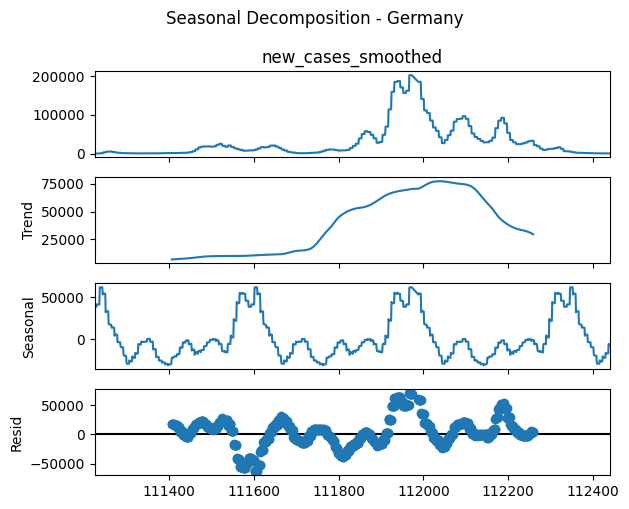

<Figure size 1000x600 with 0 Axes>

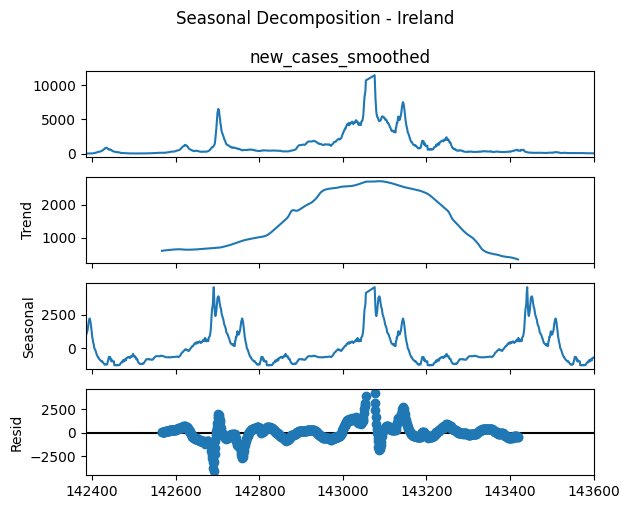

<Figure size 1000x600 with 0 Axes>

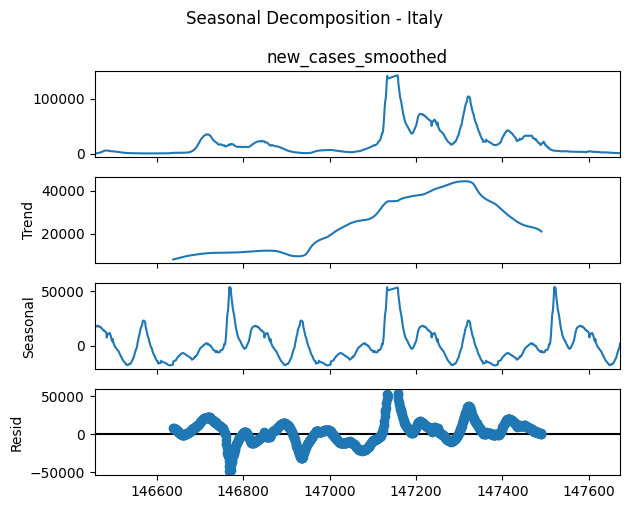

<Figure size 1000x600 with 0 Axes>

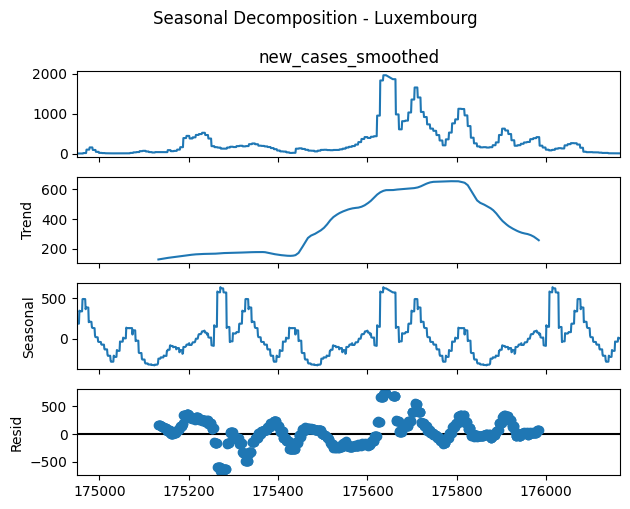

<Figure size 1000x600 with 0 Axes>

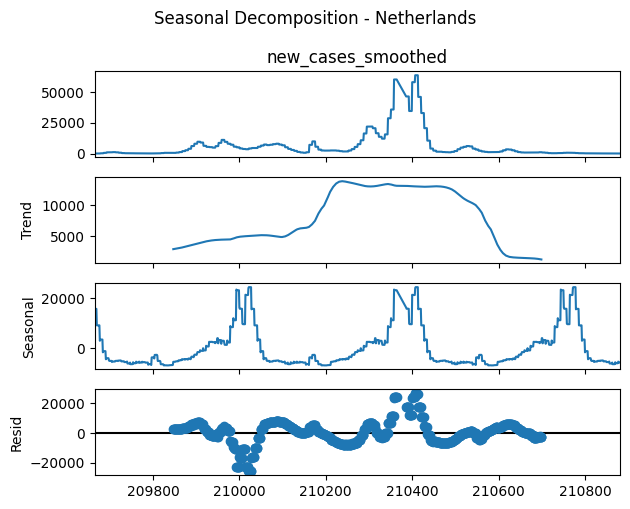

<Figure size 1000x600 with 0 Axes>

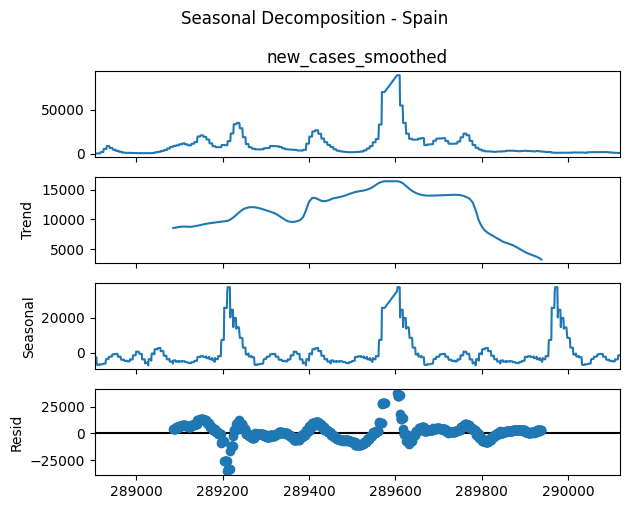

<Figure size 1000x600 with 0 Axes>

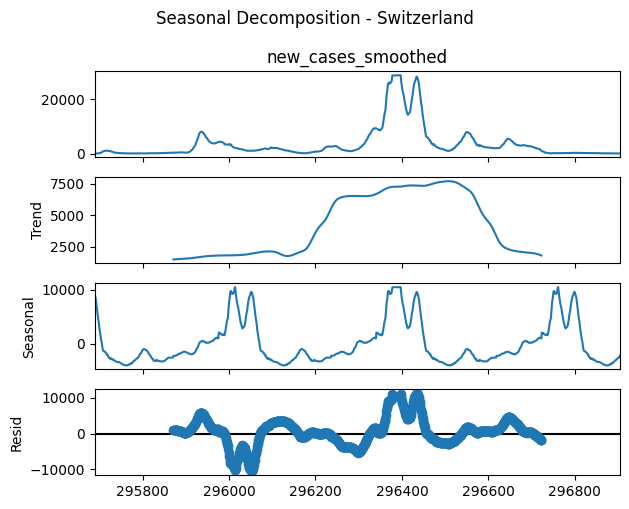

<Figure size 1000x600 with 0 Axes>

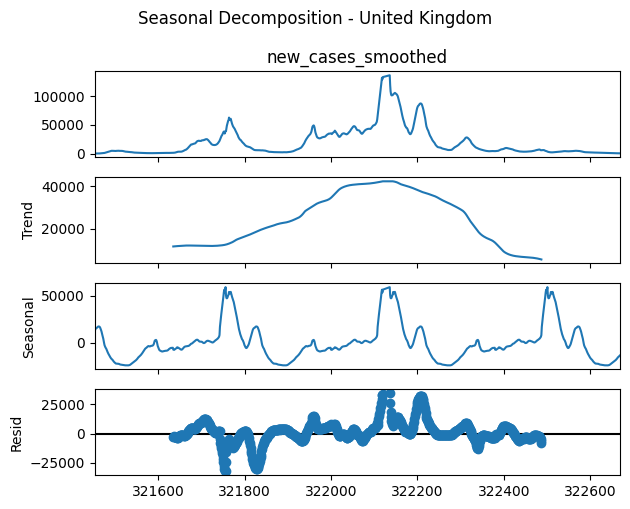

In [13]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose


for country in cleaned_df['location'].unique():
    country_data = cleaned_df[cleaned_df['location'] == country]
    result = seasonal_decompose(country_data['new_cases_smoothed'], period=365)
    
    plt.figure(figsize=(10, 6))
    
    # Create plots
    result.plot()
    
    # Set the title with a higher y value to shift it up
    plt.suptitle(f'Seasonal Decomposition - {country}', y=1.05)
    
    # Display the figure
    plt.show()



### Testing for Stationarity

In [27]:
from statsmodels.tsa.stattools import adfuller

for country in cleaned_df['location'].unique():
    country_data = cleaned_df[cleaned_df['location'] == country]
    result = adfuller(country_data['new_cases_smoothed'].values)
    
    print(f'Results for {country}:')
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('---------------------------------------------')


Results for Belgium:
ADF Statistic: -2.367410
p-value: 0.151147
---------------------------------------------
Results for France:
ADF Statistic: -3.222253
p-value: 0.018732
---------------------------------------------
Results for Germany:
ADF Statistic: -2.678159
p-value: 0.077895
---------------------------------------------
Results for Ireland:
ADF Statistic: -2.653269
p-value: 0.082480
---------------------------------------------
Results for Italy:
ADF Statistic: -3.351252
p-value: 0.012737
---------------------------------------------
Results for Luxembourg:
ADF Statistic: -2.627467
p-value: 0.087452
---------------------------------------------
Results for Netherlands:
ADF Statistic: -3.374764
p-value: 0.011850
---------------------------------------------
Results for Spain:
ADF Statistic: -3.733559
p-value: 0.003665
---------------------------------------------
Results for Switzerland:
ADF Statistic: -2.157995
p-value: 0.221842
---------------------------------------------
Resu

Stationary (p-value < 0.05): France, Italy, Netherlands, Spain

Non-Stationary (p-value > 0.05): Belgium, Germany, Ireland, Luxembourg, Switzerland, United Kingdom


### Splitting into Stationary and Non-Stationary Sets

In [15]:
# setting locations
stationary_locations = ['France', 'Italy', 'Netherlands', 'Spain']
non_stationary_locations = ['Belgium', 'Germany', 'Ireland', 'Luxembourg', 'Switzerland', 'United Kingdom']


# creating df
stationary_df = cleaned_df[cleaned_df['location'].isin(stationary_locations)]
non_stationary_df = cleaned_df[cleaned_df['location'].isin(non_stationary_locations)]


### Differencing Non-Stationary Data

In [29]:
missing_values_count = non_stationary_df['new_cases_smoothed'].isnull().sum()
print(missing_values_count)



0


#### First Order

In [33]:
# Define a list of unique locations
locations = non_stationary_df['location'].unique()

# Create an empty DataFrame to store the differenced data
differenced_df = pd.DataFrame()

# Loop through each location and apply first-order differencing
for location in locations:
    # Extract data for the current location
    subset = non_stationary_df[non_stationary_df['location'] == location].copy()

    # Apply first-order differencing to the target variable
    subset['new_cases_smoothed_diff'] = subset['new_cases_smoothed'].diff(1)

    # Append the differenced data to the new DataFrame
    differenced_df = pd.concat([differenced_df, subset])

differenced_df = differenced_df.fillna(0)

In [36]:
for country in differenced_df['location'].unique():
    country_data = differenced_df[differenced_df['location'] == country]
    result = adfuller(country_data['new_cases_smoothed_diff'].values)
    
    print(f'Results for {country}:')
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('---------------------------------------------')

Results for Belgium:
ADF Statistic: -8.994337
p-value: 0.000000
---------------------------------------------
Results for Germany:
ADF Statistic: -5.966700
p-value: 0.000000
---------------------------------------------
Results for Ireland:
ADF Statistic: -9.729609
p-value: 0.000000
---------------------------------------------
Results for Luxembourg:
ADF Statistic: -9.350250
p-value: 0.000000
---------------------------------------------
Results for Switzerland:
ADF Statistic: -7.598925
p-value: 0.000000
---------------------------------------------
Results for United Kingdom:
ADF Statistic: -7.173192
p-value: 0.000000
---------------------------------------------


### Auto-ARIMA tuning for ambiguous p, q values

In [20]:
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error


# Define the list of countries in your dataset
countries = cleaned_df['location'].unique()

# Function to fit auto ARIMA for each country and print optimal (p, d, q)
def fit_auto_arima(data, country):
    subset = data[data['location'] == country]

    # Extract the target variable (replace 'your_column_of_interest' with your actual column name)
    y = subset['new_cases_smoothed']

    # Fit auto ARIMA
    model = pm.auto_arima(y, seasonal=False, suppress_warnings=True)
    
    # Print optimal (p, d, q) values
    print(f'Optimal (p, d, q) for {country}: {model.order}')

# Apply the function for each country
for country in countries:
    fit_auto_arima(cleaned_df, country)

Optimal (p, d, q) for Belgium: (1, 1, 2)
Optimal (p, d, q) for France: (0, 1, 0)
Optimal (p, d, q) for Germany: (0, 1, 0)


/Users/timhong/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/Users/timhong/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1
/Users/timhong/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/Users/timhong/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1
/Users/timhong/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: divide by zero encountered in reciprocal


Optimal (p, d, q) for Ireland: (4, 1, 2)
Optimal (p, d, q) for Italy: (2, 1, 2)
Optimal (p, d, q) for Luxembourg: (0, 1, 0)
Optimal (p, d, q) for Netherlands: (0, 1, 0)


/Users/timhong/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/Users/timhong/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1
/Users/timhong/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/Users/timhong/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1
/Users/timhong/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: divide by zero encountered in reciprocal


Optimal (p, d, q) for Spain: (0, 1, 0)
Optimal (p, d, q) for Switzerland: (3, 1, 3)
Optimal (p, d, q) for United Kingdom: (4, 1, 0)


Optimal (p, d, q) for Belgium: (1, 1, 2)
Optimal (p, d, q) for France: (0, 1, 0)
Optimal (p, d, q) for Germany: (0, 1, 0)
Optimal (p, d, q) for Ireland: (4, 1, 2)
Optimal (p, d, q) for Italy: (2, 1, 2)
Optimal (p, d, q) for Luxembourg: (0, 1, 0)
Optimal (p, d, q) for Netherlands: (0, 1, 0)
Optimal (p, d, q) for Spain: (0, 1, 0)
Optimal (p, d, q) for Switzerland: (3, 1, 3)
Optimal (p, d, q) for United Kingdom: (4, 1, 0)

## Manually Setting p, d, q by Country

In [57]:
## setting date as index across
stationary_df.set_index('date', inplace=True)
differenced_df.set_index('date', inplace=True)

### I. Stationary

1. France

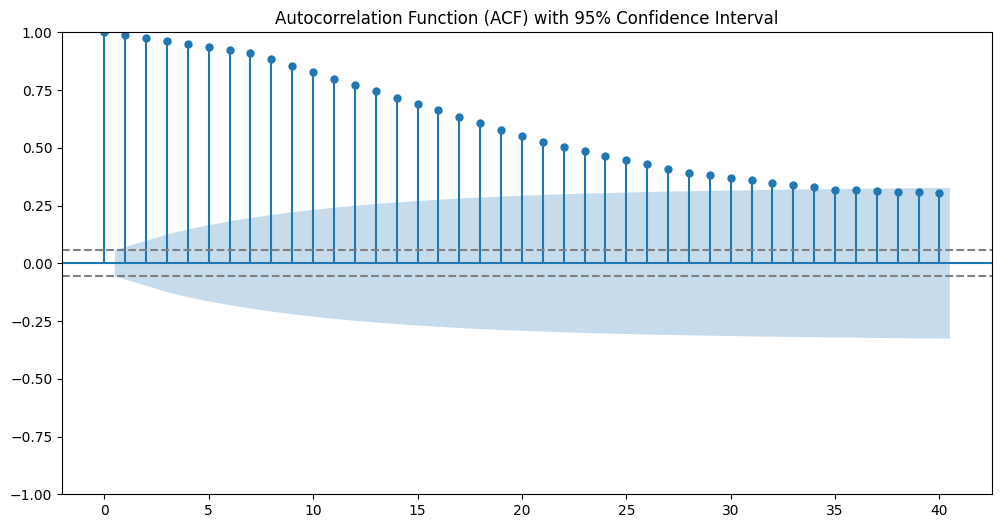

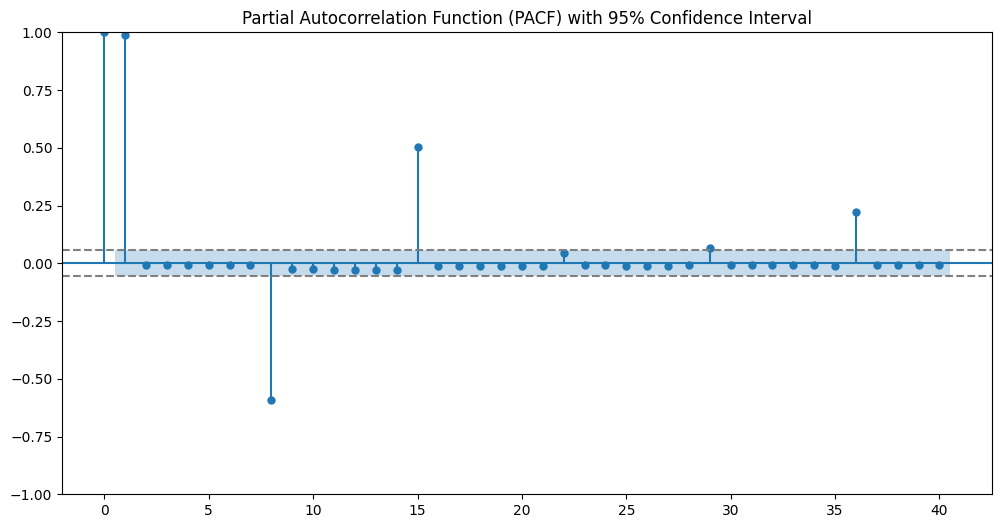

In [58]:
import statsmodels.api as sm
france_df = stationary_df[stationary_df['location'] == 'France']

# Extract the relevant columns
target_variable = france_df['new_cases_smoothed']

# Plot ACF with threshold lines
fig, ax = plt.subplots(figsize=(12, 6))
sm.graphics.tsa.plot_acf(target_variable, lags=40, ax=ax)
ax.axhline(y=1.96 / (target_variable.shape[0])**0.5, linestyle='--', color='gray')
ax.axhline(y=-1.96 / (target_variable.shape[0])**0.5, linestyle='--', color='gray')
plt.title('Autocorrelation Function (ACF) with 95% Confidence Interval')
plt.show()

# Plot PACF with threshold lines
fig, ax = plt.subplots(figsize=(12, 6))
sm.graphics.tsa.plot_pacf(target_variable, lags=40, ax=ax)
ax.axhline(y=1.96 / (target_variable.shape[0])**0.5, linestyle='--', color='gray')
ax.axhline(y=-1.96 / (target_variable.shape[0])**0.5, linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function (PACF) with 95% Confidence Interval')
plt.show()

ACF tails off
PACF spikes every 7 lags - could need differencing 
ARIMA(0, 1, 0)

In [63]:
train_size = 0.8  
france_split = int(len(france_df) * train_size)
france_train = france_df.iloc[:france_split]
france_test = france_df.iloc[france_split:]

france_train = france_train.drop(columns = ['location'])
france_test = france_test.drop(columns = ['location'])

print('Train set shape:', france_train.shape)
print('Test set shape:', france_test.shape)

Train set shape: (956, 1)
Test set shape: (240, 1)


/Users/timhong/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/timhong/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/timhong/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/timhong/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer

Train RMSE: 6094.991290450465
Test RMSE: 25499.733054300203


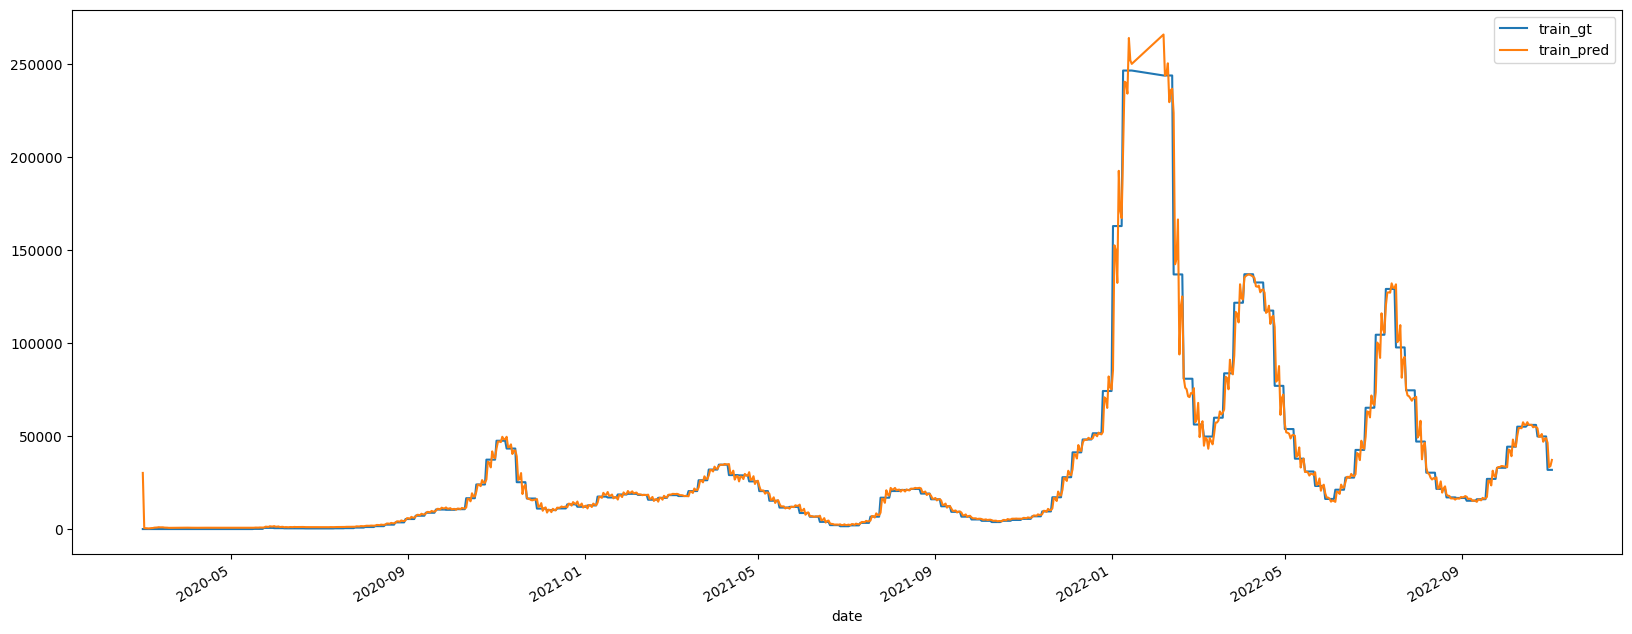

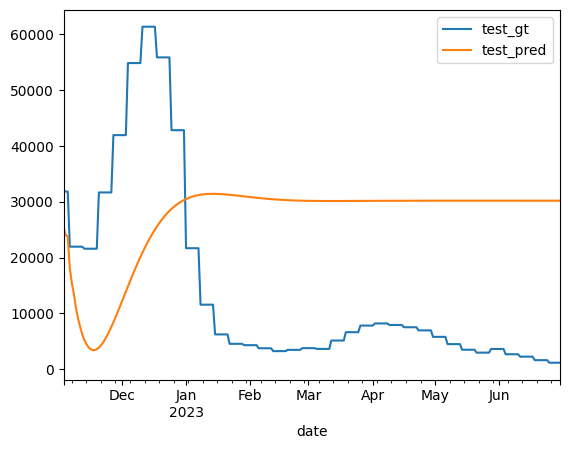

In [82]:
model = ARIMA(france_train, order=(4, 0, 4))
model = model.fit()
train_pred=model.fittedvalues
train_pred.index = france_train.index
pd.concat([france_train, train_pred], axis=1).plot(figsize=(20, 8))
plt.legend(['train_gt', 'train_pred'])
test_pred = model.predict(start=len(france_train), end=len(france_train)+len(france_test)-1, dynamic=True)
test_pred.index = france_test.index
pd.concat([france_test, test_pred], axis=1).plot()
plt.legend(['test_gt', 'test_pred'])
train_rmse = np.sqrt(mean_squared_error(france_train, train_pred))
test_rmse = np.sqrt(mean_squared_error(france_test, test_pred))

print(f'Train RMSE: {train_rmse}')
print(f'Test RMSE: {test_rmse}')

2. Italy

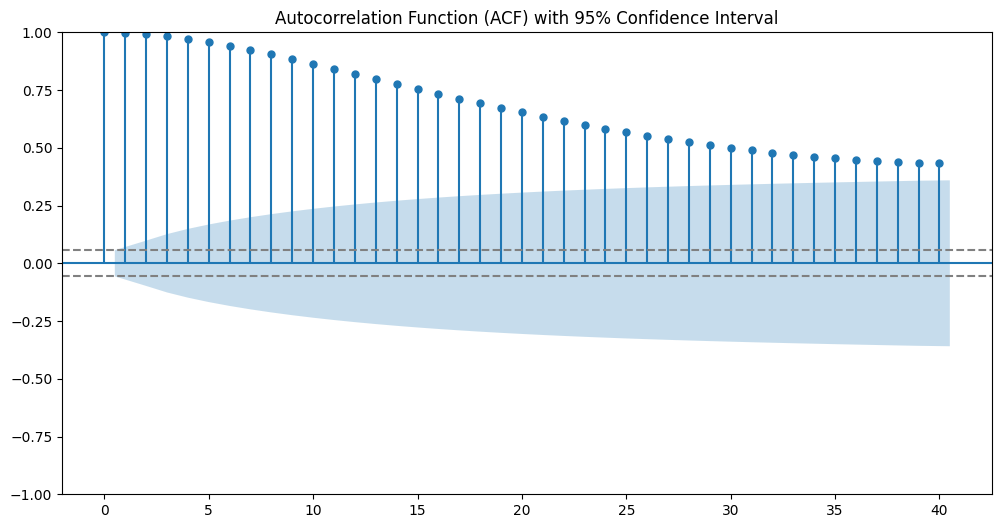

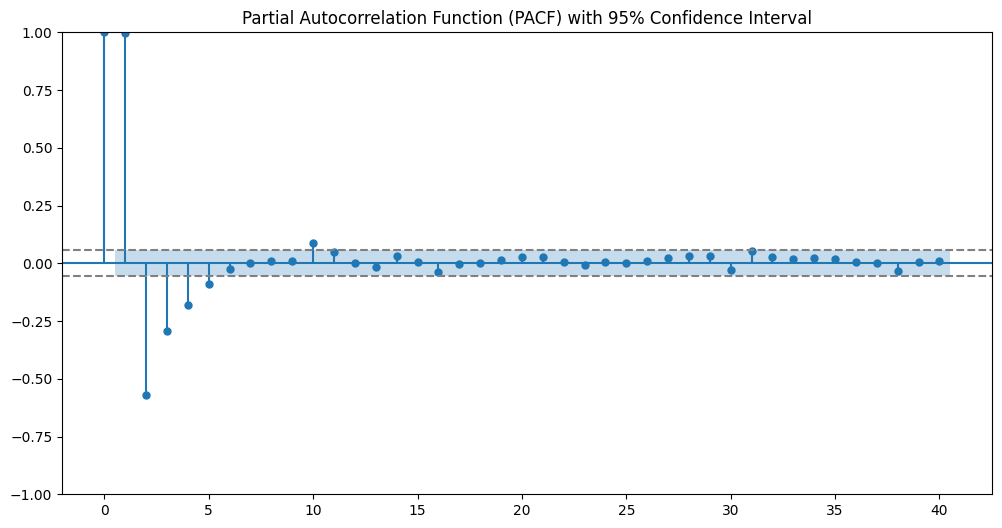

In [78]:
import statsmodels.api as sm
italy_df = stationary_df[stationary_df['location'] == 'Italy']

# Extract the relevant columns
target_variable = italy_df['new_cases_smoothed']

# Plot ACF with threshold lines
fig, ax = plt.subplots(figsize=(12, 6))
sm.graphics.tsa.plot_acf(target_variable, lags=40, ax=ax)
ax.axhline(y=1.96 / (target_variable.shape[0])**0.5, linestyle='--', color='gray')
ax.axhline(y=-1.96 / (target_variable.shape[0])**0.5, linestyle='--', color='gray')
plt.title('Autocorrelation Function (ACF) with 95% Confidence Interval')
plt.show()

# Plot PACF with threshold lines
fig, ax = plt.subplots(figsize=(12, 6))
sm.graphics.tsa.plot_pacf(target_variable, lags=40, ax=ax)
ax.axhline(y=1.96 / (target_variable.shape[0])**0.5, linestyle='--', color='gray')
ax.axhline(y=-1.96 / (target_variable.shape[0])**0.5, linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function (PACF) with 95% Confidence Interval')
plt.show()

ACF tails off
PACF cuts off more or less after 2 or 3
Try ARIMA (2, 0, 0) and ARIMA (3, 0, 0)

/Users/timhong/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/timhong/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/timhong/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/timhong/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer

Train RMSE: 1177.572035953436
Test RMSE: 10327.384837710853


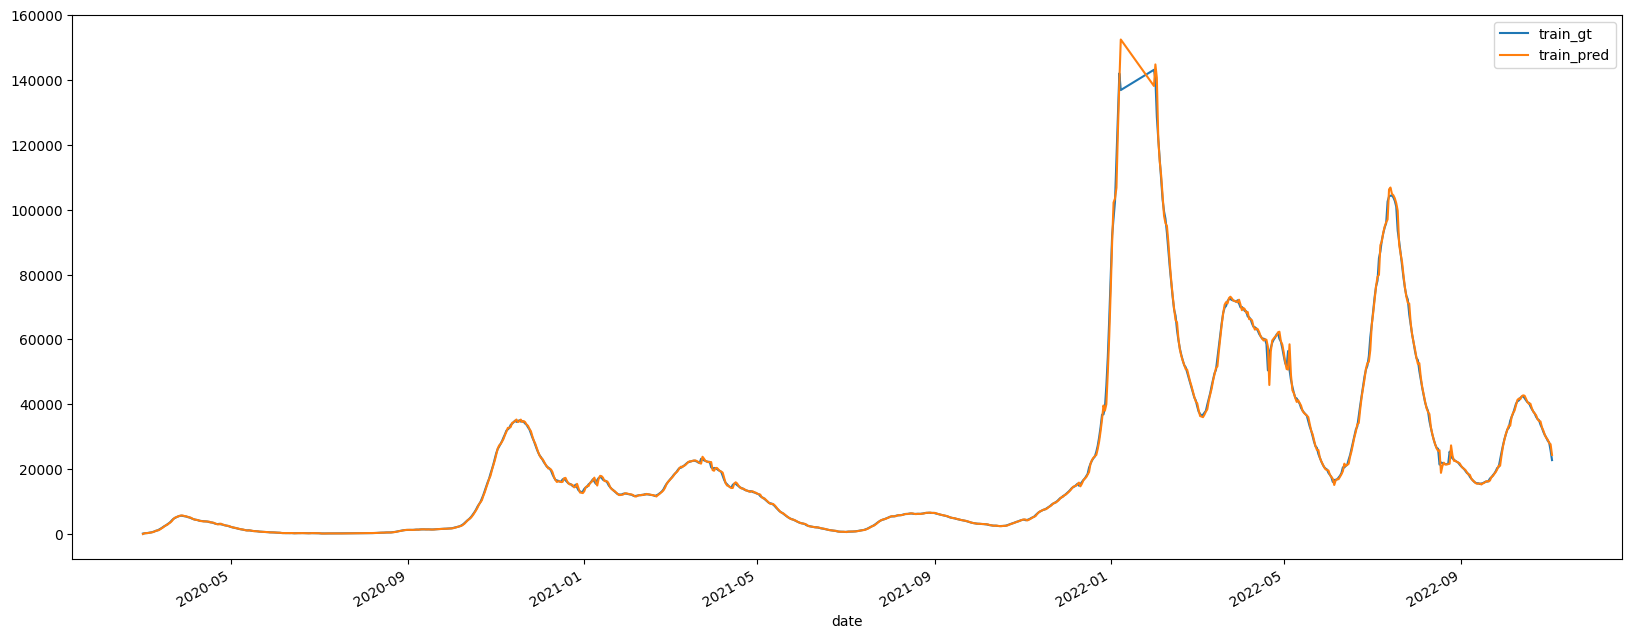

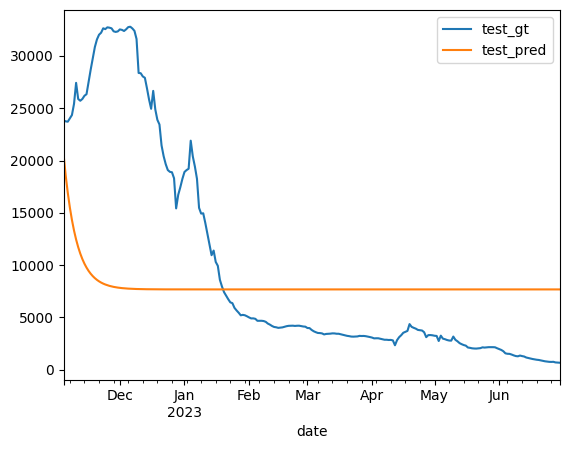

In [80]:
train_size = 0.8  
italy_split = int(len(italy_df) * train_size)
italy_train = italy_df.iloc[:italy_split]
italy_test = italy_df.iloc[italy_split:]

italy_train = italy_train.drop(columns = ['location'])
italy_test = italy_test.drop(columns = ['location'])

model = ARIMA(italy_train, order=(2, 1, 0))
model = model.fit()
train_pred=model.fittedvalues
train_pred.index = italy_train.index
pd.concat([italy_train, train_pred], axis=1).plot(figsize=(20, 8))
plt.legend(['train_gt', 'train_pred'])
test_pred = model.predict(start=len(italy_train), end=len(italy_train)+len(italy_test)-1, dynamic=True)
test_pred.index = italy_test.index
pd.concat([italy_test, test_pred], axis=1).plot()
plt.legend(['test_gt', 'test_pred'])
train_rmse = np.sqrt(mean_squared_error(italy_train, train_pred))
test_rmse = np.sqrt(mean_squared_error(italy_test, test_pred))

print(f'Train RMSE: {train_rmse}')
print(f'Test RMSE: {test_rmse}')

3. Netherlands

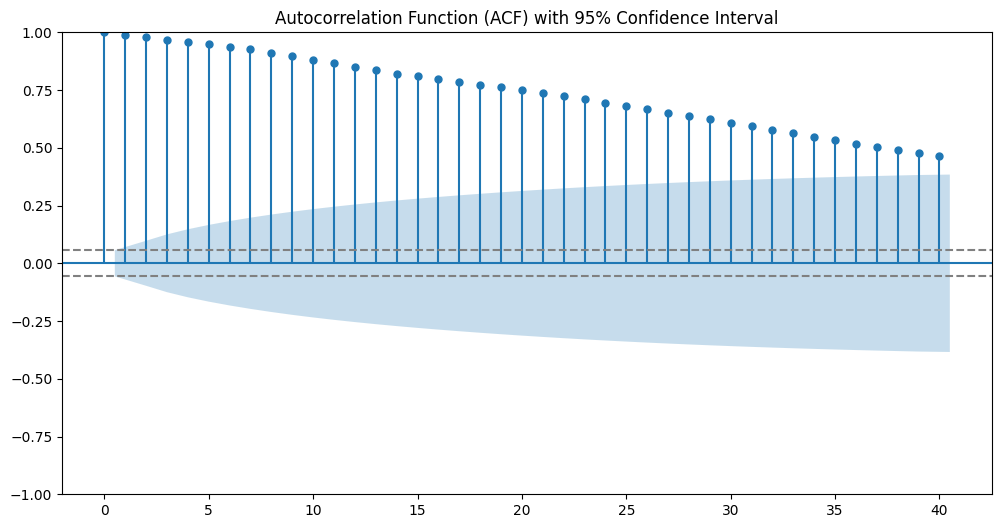

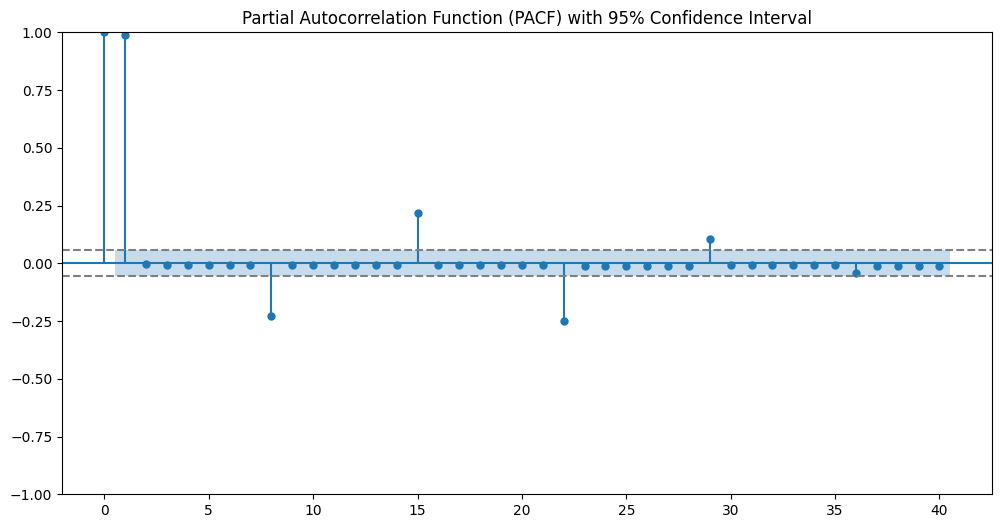

In [43]:
import statsmodels.api as sm
netherlands_df = stationary_df[stationary_df['location'] == 'Netherlands']

# Extract the relevant columns
target_variable = netherlands_df['new_cases_smoothed']

# Plot ACF with threshold lines
fig, ax = plt.subplots(figsize=(12, 6))
sm.graphics.tsa.plot_acf(target_variable, lags=40, ax=ax)
ax.axhline(y=1.96 / (target_variable.shape[0])**0.5, linestyle='--', color='gray')
ax.axhline(y=-1.96 / (target_variable.shape[0])**0.5, linestyle='--', color='gray')
plt.title('Autocorrelation Function (ACF) with 95% Confidence Interval')
plt.show()

# Plot PACF with threshold lines
fig, ax = plt.subplots(figsize=(12, 6))
sm.graphics.tsa.plot_pacf(target_variable, lags=40, ax=ax)
ax.axhline(y=1.96 / (target_variable.shape[0])**0.5, linestyle='--', color='gray')
ax.axhline(y=-1.96 / (target_variable.shape[0])**0.5, linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function (PACF) with 95% Confidence Interval')
plt.show()

ACF tails off
PACF spikes every 7 lags - could need differencing

4. Spain

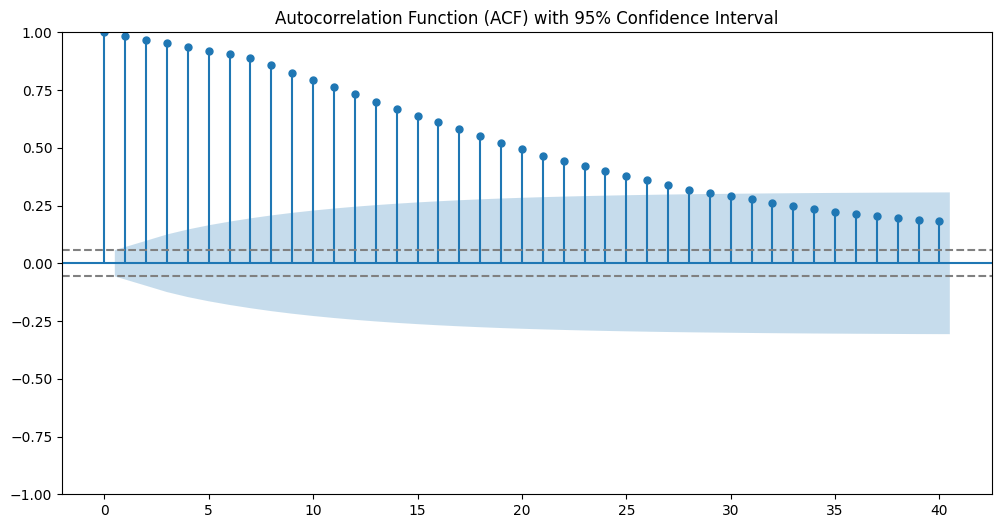

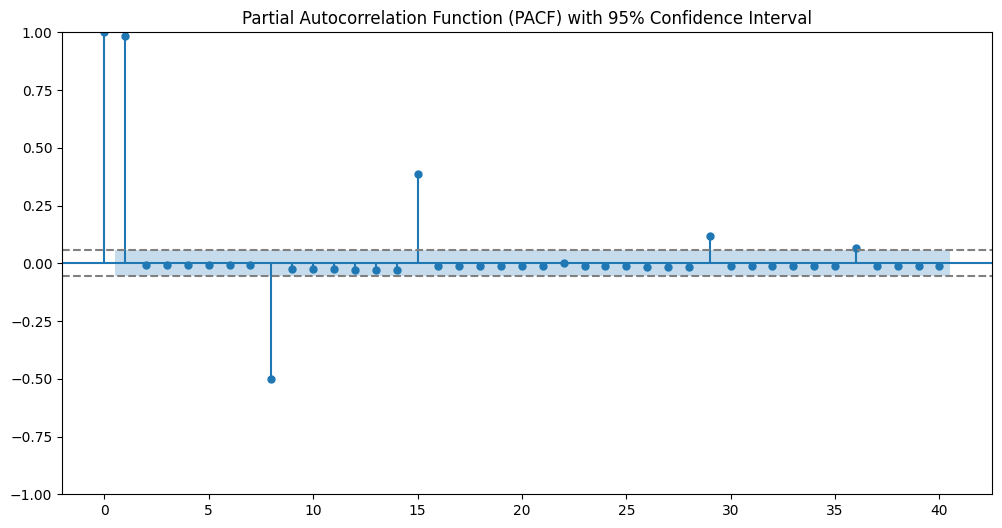

In [44]:
import statsmodels.api as sm
spain_df = stationary_df[stationary_df['location'] == 'Spain']

# Extract the relevant columns
target_variable = spain_df['new_cases_smoothed']

# Plot ACF with threshold lines
fig, ax = plt.subplots(figsize=(12, 6))
sm.graphics.tsa.plot_acf(target_variable, lags=40, ax=ax)
ax.axhline(y=1.96 / (target_variable.shape[0])**0.5, linestyle='--', color='gray')
ax.axhline(y=-1.96 / (target_variable.shape[0])**0.5, linestyle='--', color='gray')
plt.title('Autocorrelation Function (ACF) with 95% Confidence Interval')
plt.show()

# Plot PACF with threshold lines
fig, ax = plt.subplots(figsize=(12, 6))
sm.graphics.tsa.plot_pacf(target_variable, lags=40, ax=ax)
ax.axhline(y=1.96 / (target_variable.shape[0])**0.5, linestyle='--', color='gray')
ax.axhline(y=-1.96 / (target_variable.shape[0])**0.5, linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function (PACF) with 95% Confidence Interval')
plt.show()

ACF tails off
PACF spikes every 7 lags - could need differencing

this could be due to new_cases_smoothed being used to fix weekly reporting!

Updated France

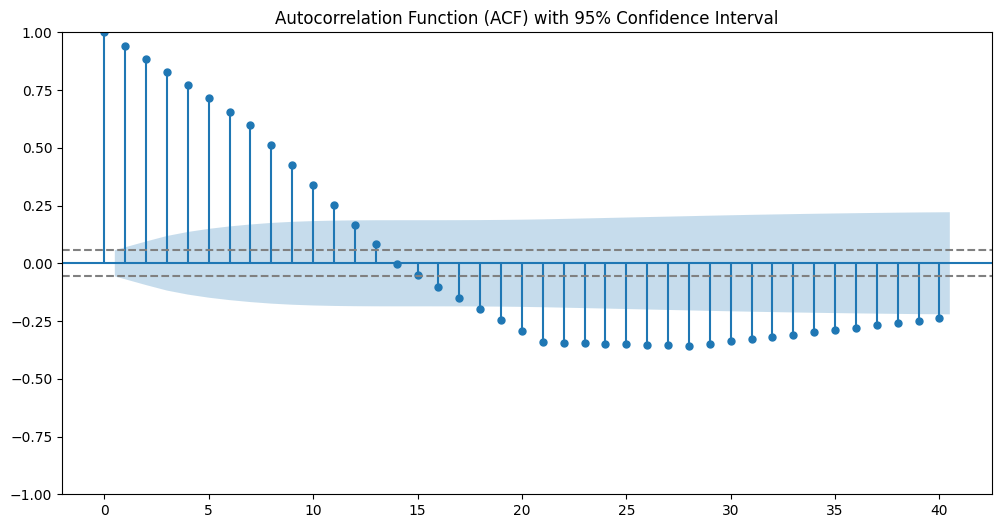

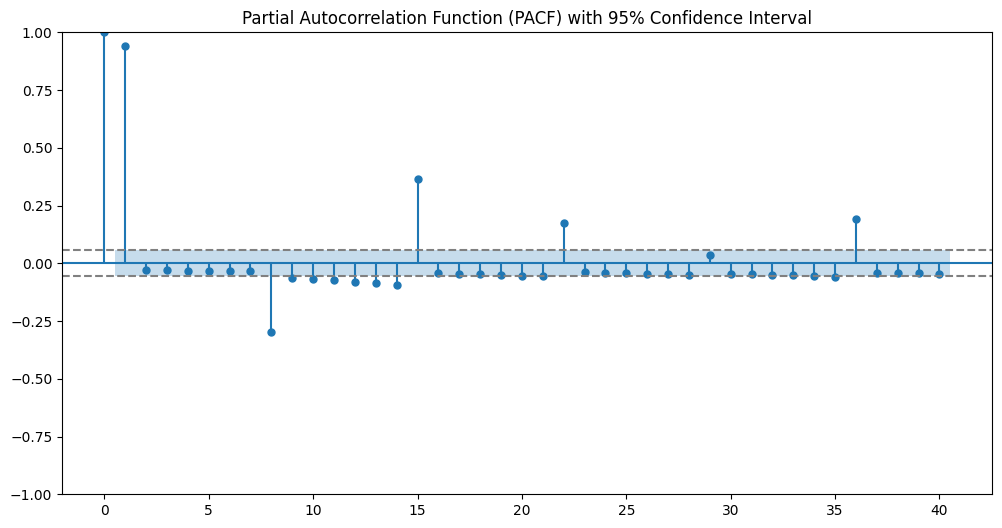

In [53]:
import statsmodels.api as sm
lagged_france_df = fixed_df[fixed_df['location'] == 'France']

# Extract the relevant columns
target_variable = lagged_france_df['new_cases_smoothed_diff']

# Plot ACF with threshold lines
fig, ax = plt.subplots(figsize=(12, 6))
sm.graphics.tsa.plot_acf(target_variable, lags=40, ax=ax)
ax.axhline(y=1.96 / (target_variable.shape[0])**0.5, linestyle='--', color='gray')
ax.axhline(y=-1.96 / (target_variable.shape[0])**0.5, linestyle='--', color='gray')
plt.title('Autocorrelation Function (ACF) with 95% Confidence Interval')
plt.show()

# Plot PACF with threshold lines
fig, ax = plt.subplots(figsize=(12, 6))
sm.graphics.tsa.plot_pacf(target_variable, lags=40, ax=ax)
ax.axhline(y=1.96 / (target_variable.shape[0])**0.5, linestyle='--', color='gray')
ax.axhline(y=-1.96 / (target_variable.shape[0])**0.5, linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function (PACF) with 95% Confidence Interval')
plt.show()

Updated Netherlands

Updated Spain

### II. Non-Stationary

5. Belgium

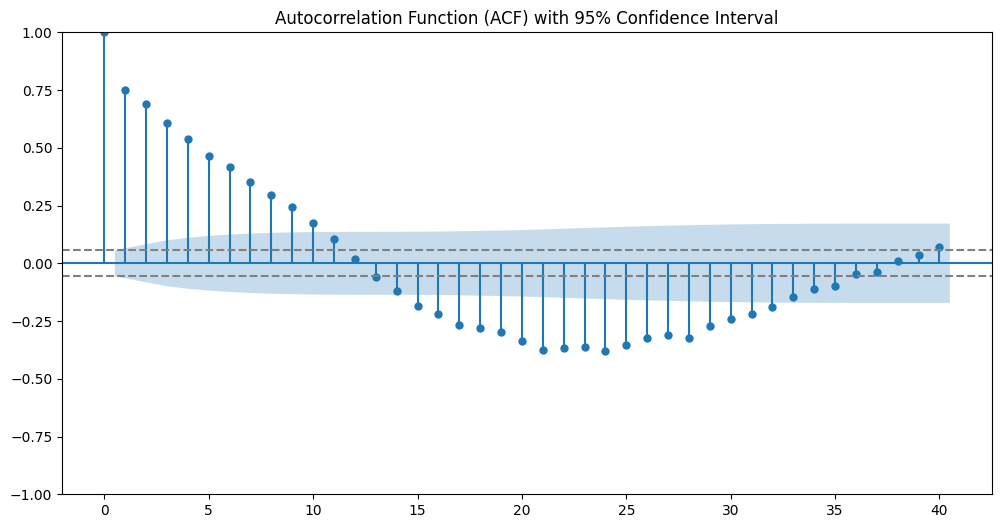

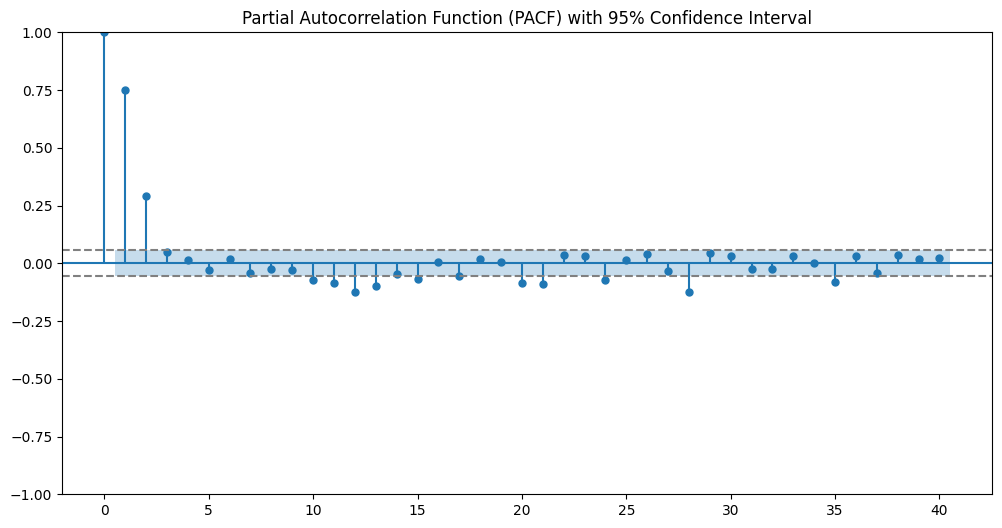

In [46]:
import statsmodels.api as sm
belgium_df = differenced_df[differenced_df['location'] == 'Belgium']

# Extract the relevant columns
target_variable = belgium_df['new_cases_smoothed_diff']

# Plot ACF with threshold lines
fig, ax = plt.subplots(figsize=(12, 6))
sm.graphics.tsa.plot_acf(target_variable, lags=40, ax=ax)
ax.axhline(y=1.96 / (target_variable.shape[0])**0.5, linestyle='--', color='gray')
ax.axhline(y=-1.96 / (target_variable.shape[0])**0.5, linestyle='--', color='gray')
plt.title('Autocorrelation Function (ACF) with 95% Confidence Interval')
plt.show()

# Plot PACF with threshold lines
fig, ax = plt.subplots(figsize=(12, 6))
sm.graphics.tsa.plot_pacf(target_variable, lags=40, ax=ax)
ax.axhline(y=1.96 / (target_variable.shape[0])**0.5, linestyle='--', color='gray')
ax.axhline(y=-1.96 / (target_variable.shape[0])**0.5, linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function (PACF) with 95% Confidence Interval')
plt.show()

ACF tails off
PACF cuts off at 3 
so p = 3, d =1, q = 0

6. Germany

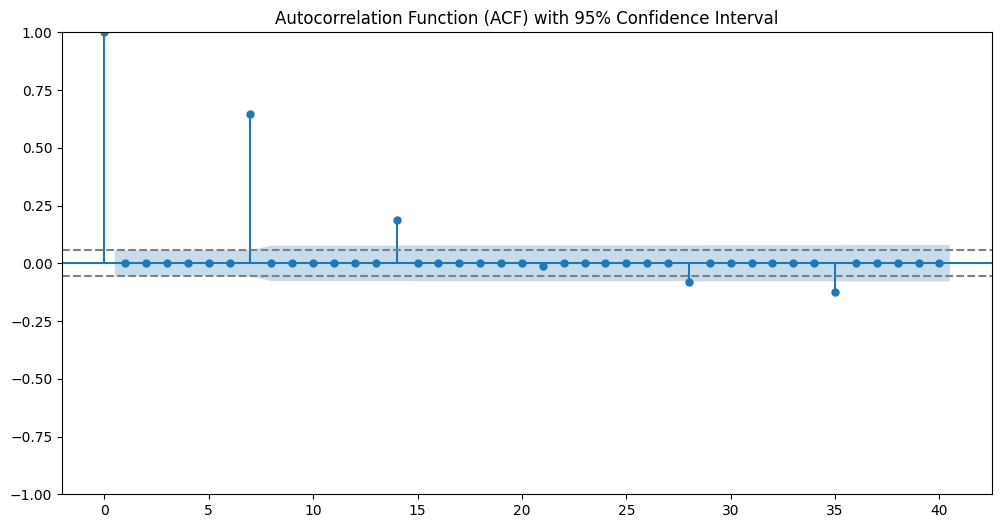

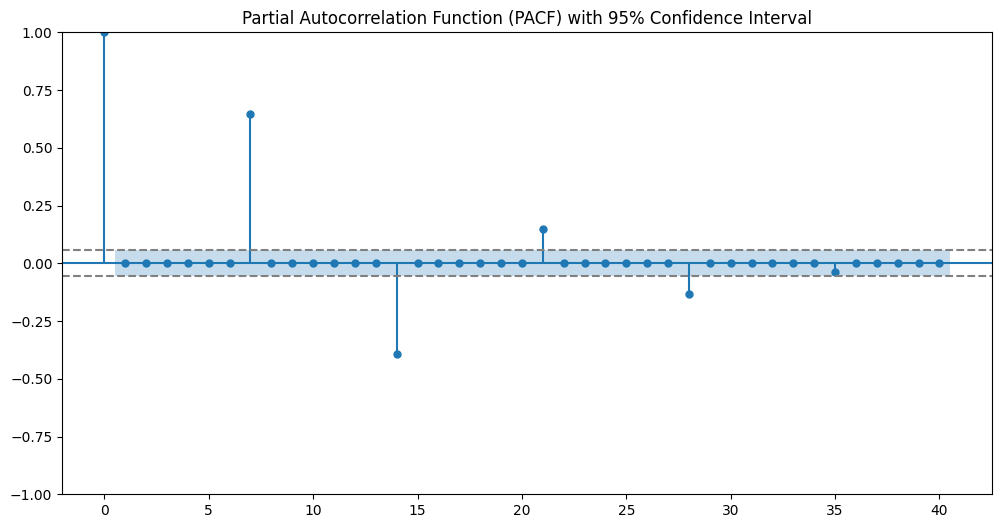

In [47]:
import statsmodels.api as sm
germany_df = differenced_df[differenced_df['location'] == 'Germany']

# Extract the relevant columns
target_variable = germany_df['new_cases_smoothed_diff']

# Plot ACF with threshold lines
fig, ax = plt.subplots(figsize=(12, 6))
sm.graphics.tsa.plot_acf(target_variable, lags=40, ax=ax)
ax.axhline(y=1.96 / (target_variable.shape[0])**0.5, linestyle='--', color='gray')
ax.axhline(y=-1.96 / (target_variable.shape[0])**0.5, linestyle='--', color='gray')
plt.title('Autocorrelation Function (ACF) with 95% Confidence Interval')
plt.show()

# Plot PACF with threshold lines
fig, ax = plt.subplots(figsize=(12, 6))
sm.graphics.tsa.plot_pacf(target_variable, lags=40, ax=ax)
ax.axhline(y=1.96 / (target_variable.shape[0])**0.5, linestyle='--', color='gray')
ax.axhline(y=-1.96 / (target_variable.shape[0])**0.5, linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function (PACF) with 95% Confidence Interval')
plt.show()

ACF cuts off after lag 3
PACF tails off
ARIMA (0, 1, 3)

7. Ireland

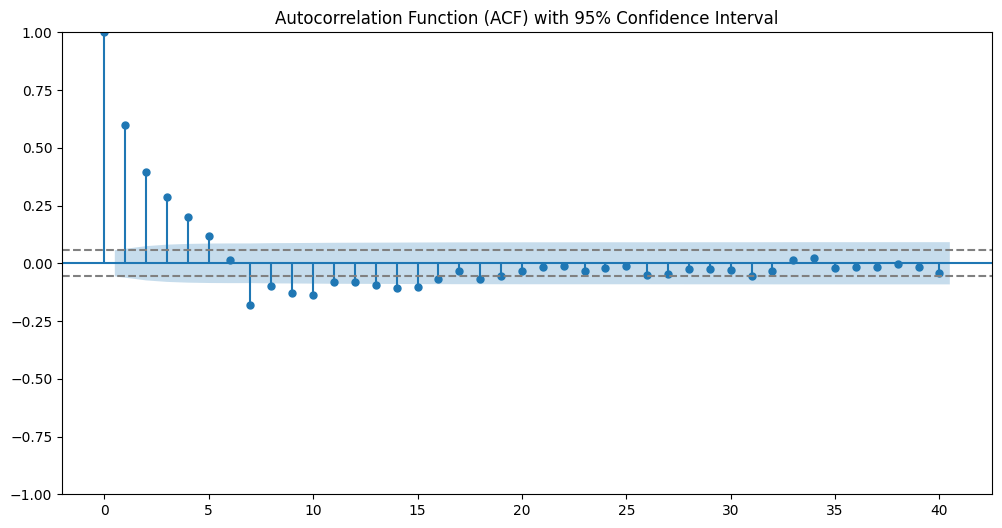

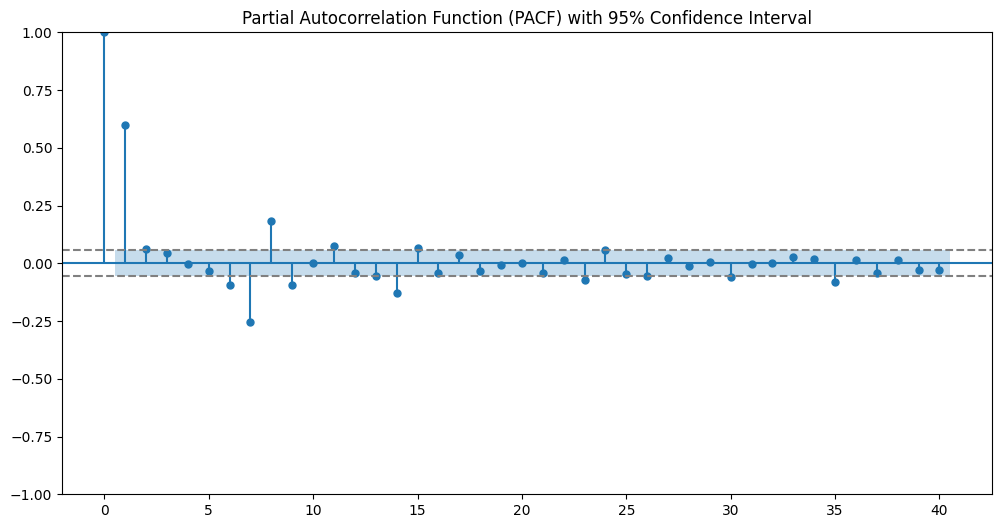

In [48]:
import statsmodels.api as sm
ireland_df = differenced_df[differenced_df['location'] == 'Ireland']

# Extract the relevant columns
target_variable = ireland_df['new_cases_smoothed_diff']

# Plot ACF with threshold lines
fig, ax = plt.subplots(figsize=(12, 6))
sm.graphics.tsa.plot_acf(target_variable, lags=40, ax=ax)
ax.axhline(y=1.96 / (target_variable.shape[0])**0.5, linestyle='--', color='gray')
ax.axhline(y=-1.96 / (target_variable.shape[0])**0.5, linestyle='--', color='gray')
plt.title('Autocorrelation Function (ACF) with 95% Confidence Interval')
plt.show()

# Plot PACF with threshold lines
fig, ax = plt.subplots(figsize=(12, 6))
sm.graphics.tsa.plot_pacf(target_variable, lags=40, ax=ax)
ax.axhline(y=1.96 / (target_variable.shape[0])**0.5, linestyle='--', color='gray')
ax.axhline(y=-1.96 / (target_variable.shape[0])**0.5, linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function (PACF) with 95% Confidence Interval')
plt.show()

ACF tails off
PACF cuts off after lag 1 (pretty much)
ARIMA (1, 1, 0)

8. Luxembourg

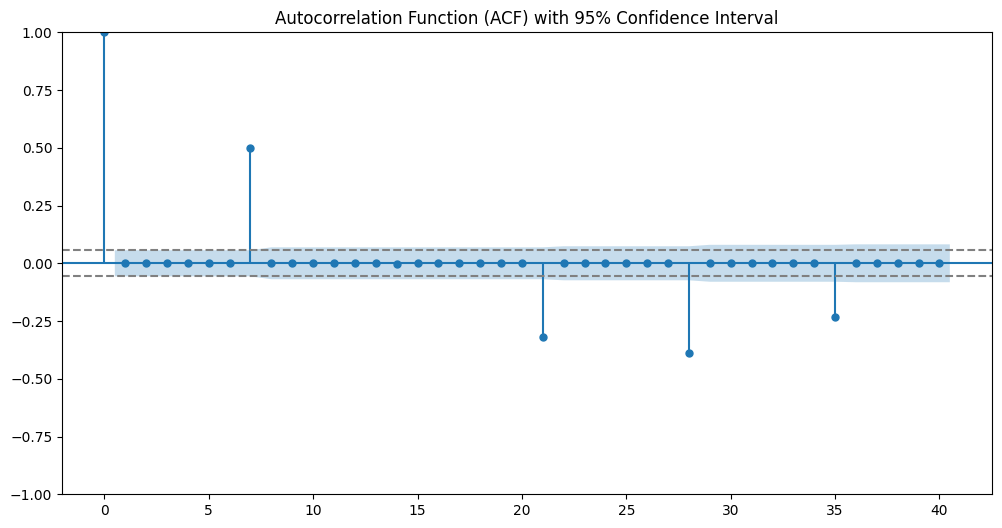

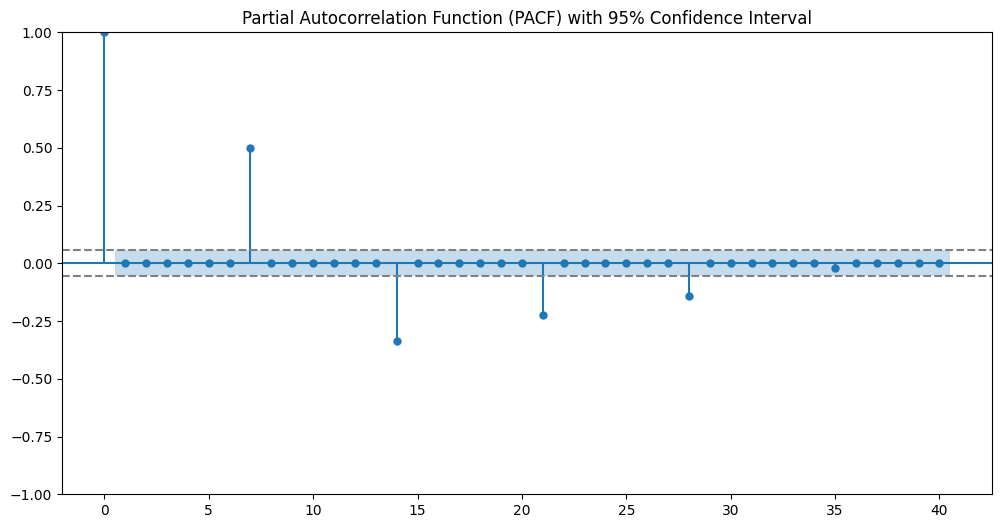

In [49]:
import statsmodels.api as sm
luxembourg_df = differenced_df[differenced_df['location'] == 'Luxembourg']

# Extract the relevant columns
target_variable = luxembourg_df['new_cases_smoothed_diff']

# Plot ACF with threshold lines
fig, ax = plt.subplots(figsize=(12, 6))
sm.graphics.tsa.plot_acf(target_variable, lags=40, ax=ax)
ax.axhline(y=1.96 / (target_variable.shape[0])**0.5, linestyle='--', color='gray')
ax.axhline(y=-1.96 / (target_variable.shape[0])**0.5, linestyle='--', color='gray')
plt.title('Autocorrelation Function (ACF) with 95% Confidence Interval')
plt.show()

# Plot PACF with threshold lines
fig, ax = plt.subplots(figsize=(12, 6))
sm.graphics.tsa.plot_pacf(target_variable, lags=40, ax=ax)
ax.axhline(y=1.96 / (target_variable.shape[0])**0.5, linestyle='--', color='gray')
ax.axhline(y=-1.96 / (target_variable.shape[0])**0.5, linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function (PACF) with 95% Confidence Interval')
plt.show()

Both ACF and PACF tail off - hard to manually find p & q (without doing it by hand)
Will use auto-ARIMA inputs: ARIMA (0, 1, 0) - random walk

9. Switzerland

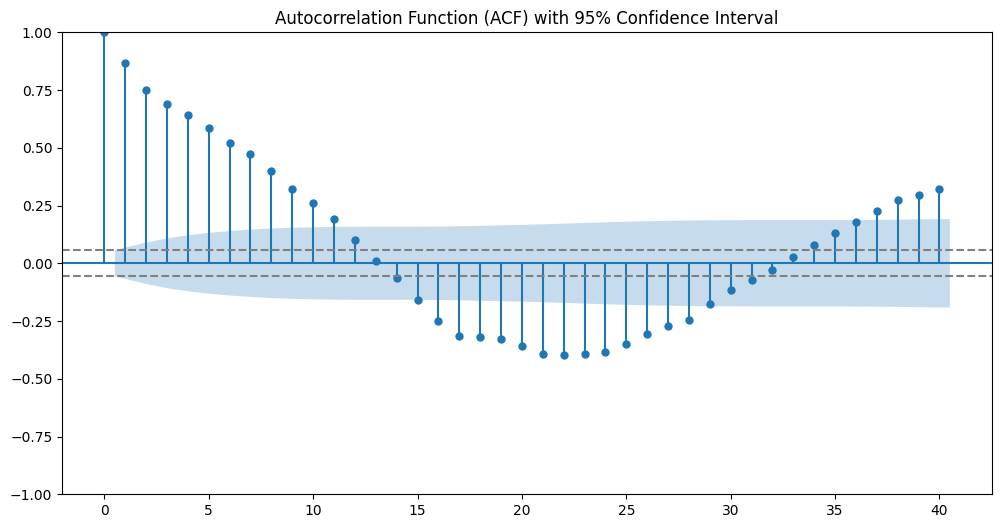

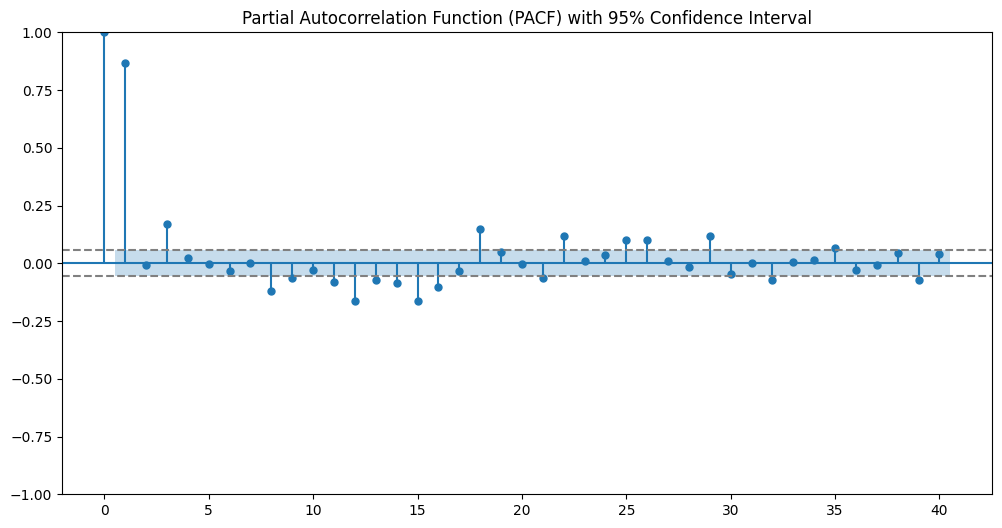

In [50]:
import statsmodels.api as sm
switzerland_df = differenced_df[differenced_df['location'] == 'Switzerland']

# Extract the relevant columns
target_variable = switzerland_df['new_cases_smoothed_diff']

# Plot ACF with threshold lines
fig, ax = plt.subplots(figsize=(12, 6))
sm.graphics.tsa.plot_acf(target_variable, lags=40, ax=ax)
ax.axhline(y=1.96 / (target_variable.shape[0])**0.5, linestyle='--', color='gray')
ax.axhline(y=-1.96 / (target_variable.shape[0])**0.5, linestyle='--', color='gray')
plt.title('Autocorrelation Function (ACF) with 95% Confidence Interval')
plt.show()

# Plot PACF with threshold lines
fig, ax = plt.subplots(figsize=(12, 6))
sm.graphics.tsa.plot_pacf(target_variable, lags=40, ax=ax)
ax.axhline(y=1.96 / (target_variable.shape[0])**0.5, linestyle='--', color='gray')
ax.axhline(y=-1.96 / (target_variable.shape[0])**0.5, linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function (PACF) with 95% Confidence Interval')
plt.show()

ACF tails off
PACF cuts off after lag 1 (or 3)? 
Try ARIMA(1, 1, 0) or ARIMA(3, 1, 0)

10. United Kingdom

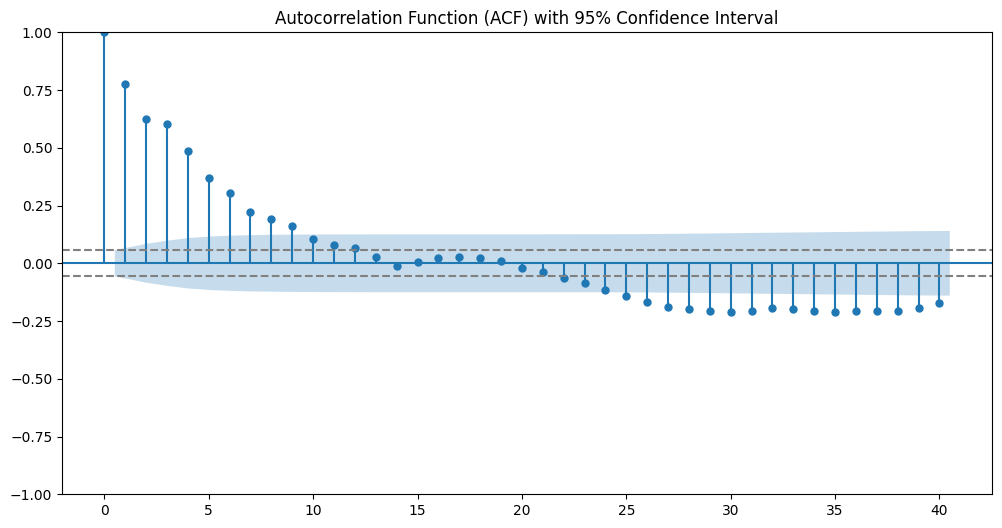

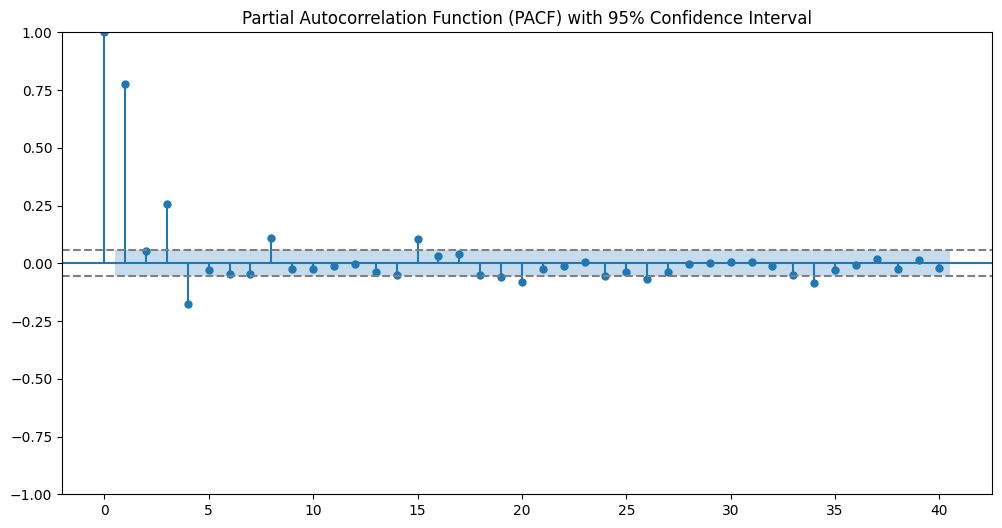

In [51]:
import statsmodels.api as sm
uk_df = differenced_df[differenced_df['location'] == 'United Kingdom']

# Extract the relevant columns
target_variable = uk_df['new_cases_smoothed_diff']

# Plot ACF with threshold lines
fig, ax = plt.subplots(figsize=(12, 6))
sm.graphics.tsa.plot_acf(target_variable, lags=40, ax=ax)
ax.axhline(y=1.96 / (target_variable.shape[0])**0.5, linestyle='--', color='gray')
ax.axhline(y=-1.96 / (target_variable.shape[0])**0.5, linestyle='--', color='gray')
plt.title('Autocorrelation Function (ACF) with 95% Confidence Interval')
plt.show()

# Plot PACF with threshold lines
fig, ax = plt.subplots(figsize=(12, 6))
sm.graphics.tsa.plot_pacf(target_variable, lags=40, ax=ax)
ax.axhline(y=1.96 / (target_variable.shape[0])**0.5, linestyle='--', color='gray')
ax.axhline(y=-1.96 / (target_variable.shape[0])**0.5, linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function (PACF) with 95% Confidence Interval')
plt.show()

ACF tails off
PACF cuts off after 3 or 4
ARIMA (3, 1, 0) or ARIMA (4, 1, 0)

# Auto ARIMA


Optimal (p, d, q) for Belgium: (1, 1, 2)
Optimal (p, d, q) for France: (0, 1, 0)
Optimal (p, d, q) for Germany: (0, 1, 0)
Optimal (p, d, q) for Ireland: (4, 1, 2)
Optimal (p, d, q) for Italy: (2, 1, 2)
Optimal (p, d, q) for Luxembourg: (0, 1, 0)
Optimal (p, d, q) for Netherlands: (0, 1, 0)
Optimal (p, d, q) for Spain: (0, 1, 0)
Optimal (p, d, q) for Switzerland: (3, 1, 3)
Optimal (p, d, q) for United Kingdom: (4, 1, 0)